# Постановка задачи

        В работе исследуется задача классификации на примере данных из соревнования kaggle: https://www.kaggle.com/c/otto-group-product-classification-challenge.
        Данные характеризуют некие неизвестные продукты. Для каждого продукта известны 93 признака. Заранее неизвестно, что характеризуют эти признаки. Каждый продукт принадлежит к некоторому из девяти классов. Для 61878 образцов классы известны. Необходимо наилучшим образом предсказать вероятности принадлежности к каждому классу для 144368 образцов с заранее неизвестным классом. Дана функция ошибки прогноза, которую необходимо минимизировать.

###### Математическая формулировка

Пусть $X\subset \mathbb{R}^{m}$ — множество описаний объектов,  $Y$ — конечное множество номеров классов. В данной задаче $|Y|=9$, $|X|=N=144368$, $m=93$. Существует неизвестная целевая зависимость — отображение $y^{*}: X\rightarrow Y$, значения которого известны только на конечном множестве $X^M = \{(x_1,y_1),\dots,(x_M,y_M)\},\ M=61878$. Требуется построить алгоритм  $a: X\rightarrow Y$, способный классифицировать произвольный объект $x \in X$ с наибольшей точностью. Если было получено предсказание $p_{i,j}$, то для оценки точности используется функция ошибки $$logloss=-\frac{1}{N}\sum\limits_{i=1}^N\sum\limits_{j=1}^M y_{i,j}\cdot\ln p_{i,j}$$ где $y_{i,j}=1$, если $i$-й объект принадлежит к классу $j$, и $y_{i,j}=0$ иначе, а $p_{i,j}$ это предсказанная вероятность принадлежности $i$-го объекта к классу $j$ с небольшой поправкой: для избежания крайних значений логарифма производится замена $p_{i,j}=\max\{10^{-15}, \min\{p_{i,j},1-10^{-15}\}\}$.

# Предварительный анализ

Ниже приведены скрипты, выполнение которых позволит сделать первый взгляд на данные.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn import feature_extraction, preprocessing

In [2]:
%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 400

In [3]:
data = pd.read_csv('train.csv')
data = data.drop(['id'], axis=1)

data_for_X = data.drop(['target'], axis=1)

y = data.target.values
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(y)
data.target = y

data.head()

feat_1  feat_2  feat_3  feat_4  feat_5  feat_6  feat_7  feat_8  feat_9  \
0       1       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       1       0   
2       0       0       0       0       0       0       0       1       0   
3       1       0       0       1       6       1       5       0       0   
4       0       0       0       0       0       0       0       0       0   

   feat_10   ...     feat_85  feat_86  feat_87  feat_88  feat_89  feat_90  \
0        0   ...           1        0        0        0        0        0   
1        0   ...           0        0        0        0        0        0   
2        0   ...           0        0        0        0        0        0   
3        1   ...           0        1        2        0        0        0   
4        0   ...           1        0        0        0        0        1   

   feat_91  feat_92  feat_93  target  
0        0        0        0       0  
1        0        0        0       0  
2        0        0        0       0  
3        0        0        0       0  
4        0        0        0       0  

[5 rows x 94 columns]

In [4]:
research = data.copy()
raw_X = data_for_X.values

## Распределения

Графики, приведенные в этом участке, иллюстрируют распределение данных в классах. Различные классы выделены цветами.

График демонстрирует плотность распределения числа нулей в различных классах

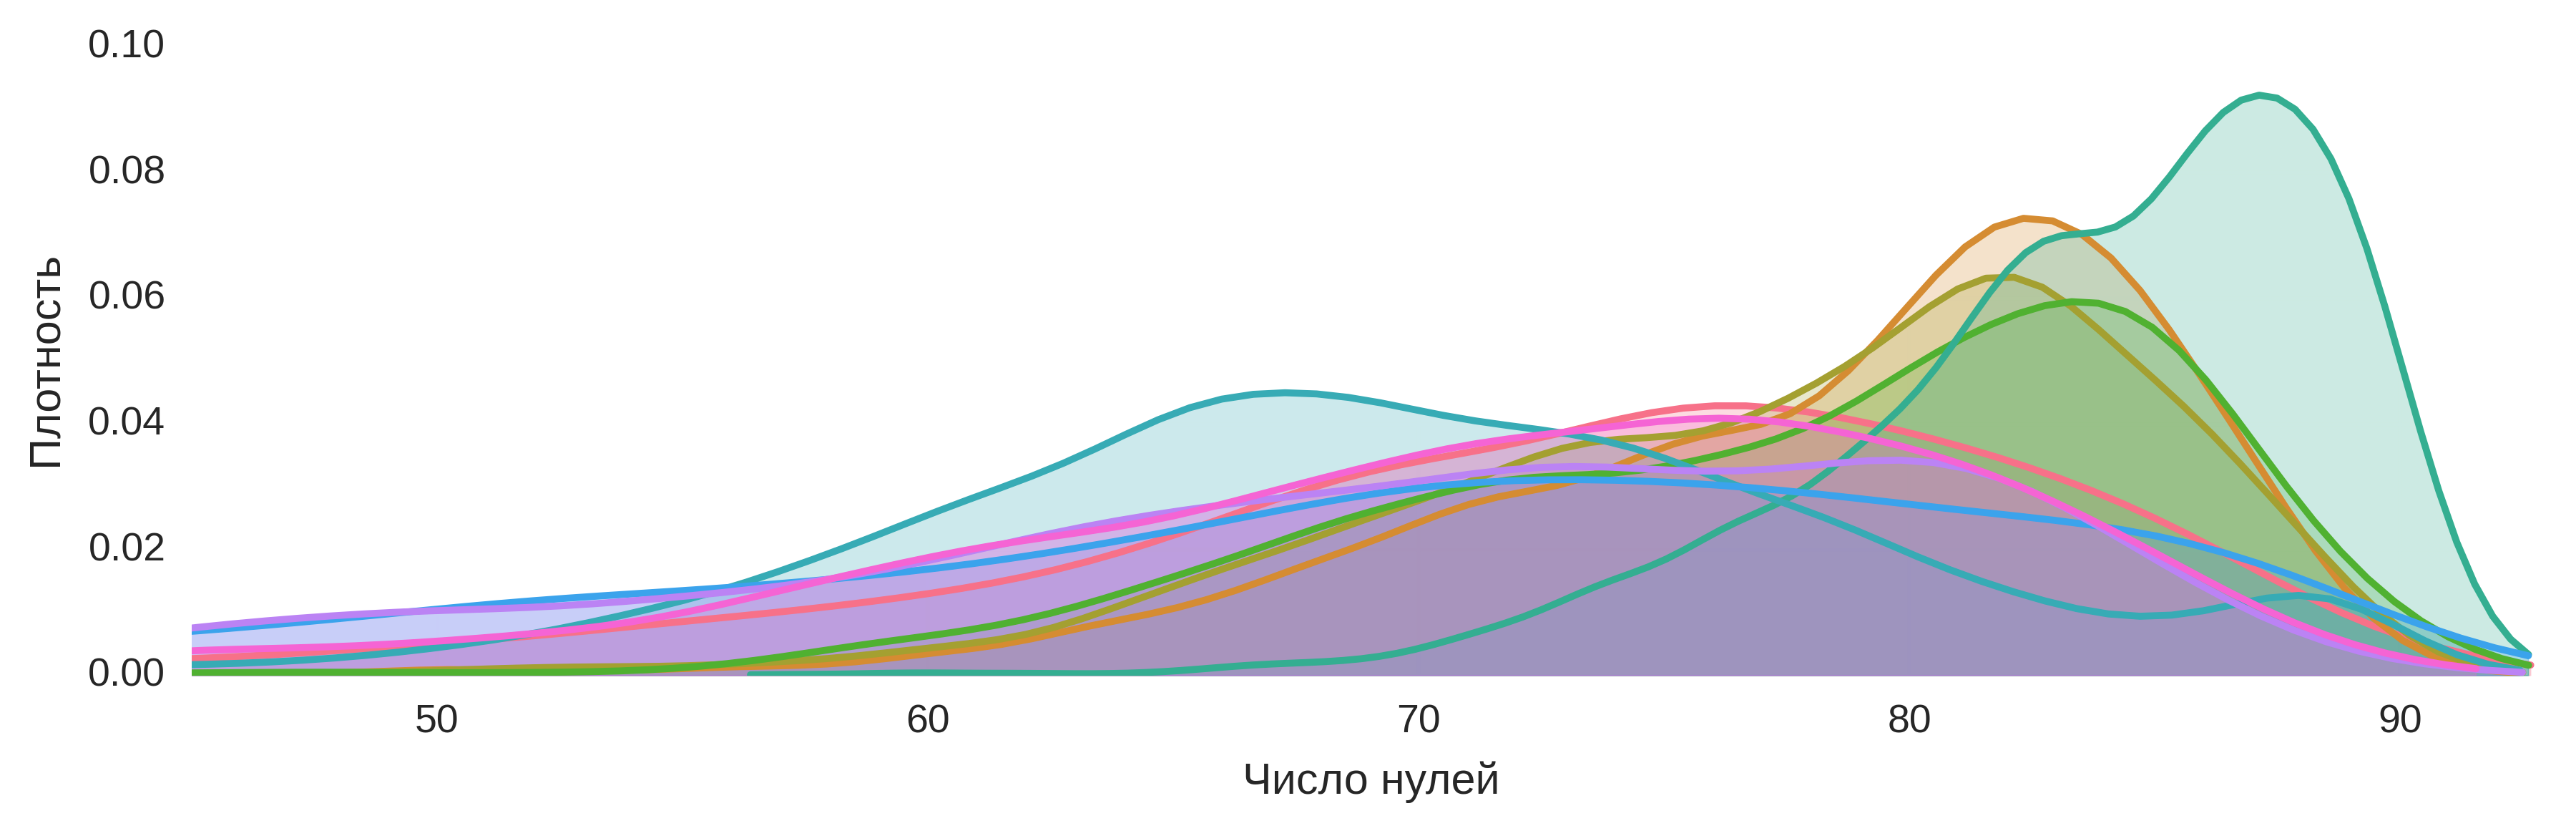

In [5]:
research['zeroes'] = np.sum(raw_X == 0, axis=1)
fg = sns.FacetGrid(research, hue="target", aspect=3)
fg.map(sns.kdeplot, "zeroes", shade=True)
fg.set_xlabels('Число нулей')
fg.set_ylabels('Плотность')
fg.set(xlim=(45, 93));
fg.set(ylim=(0.0, 0.1))

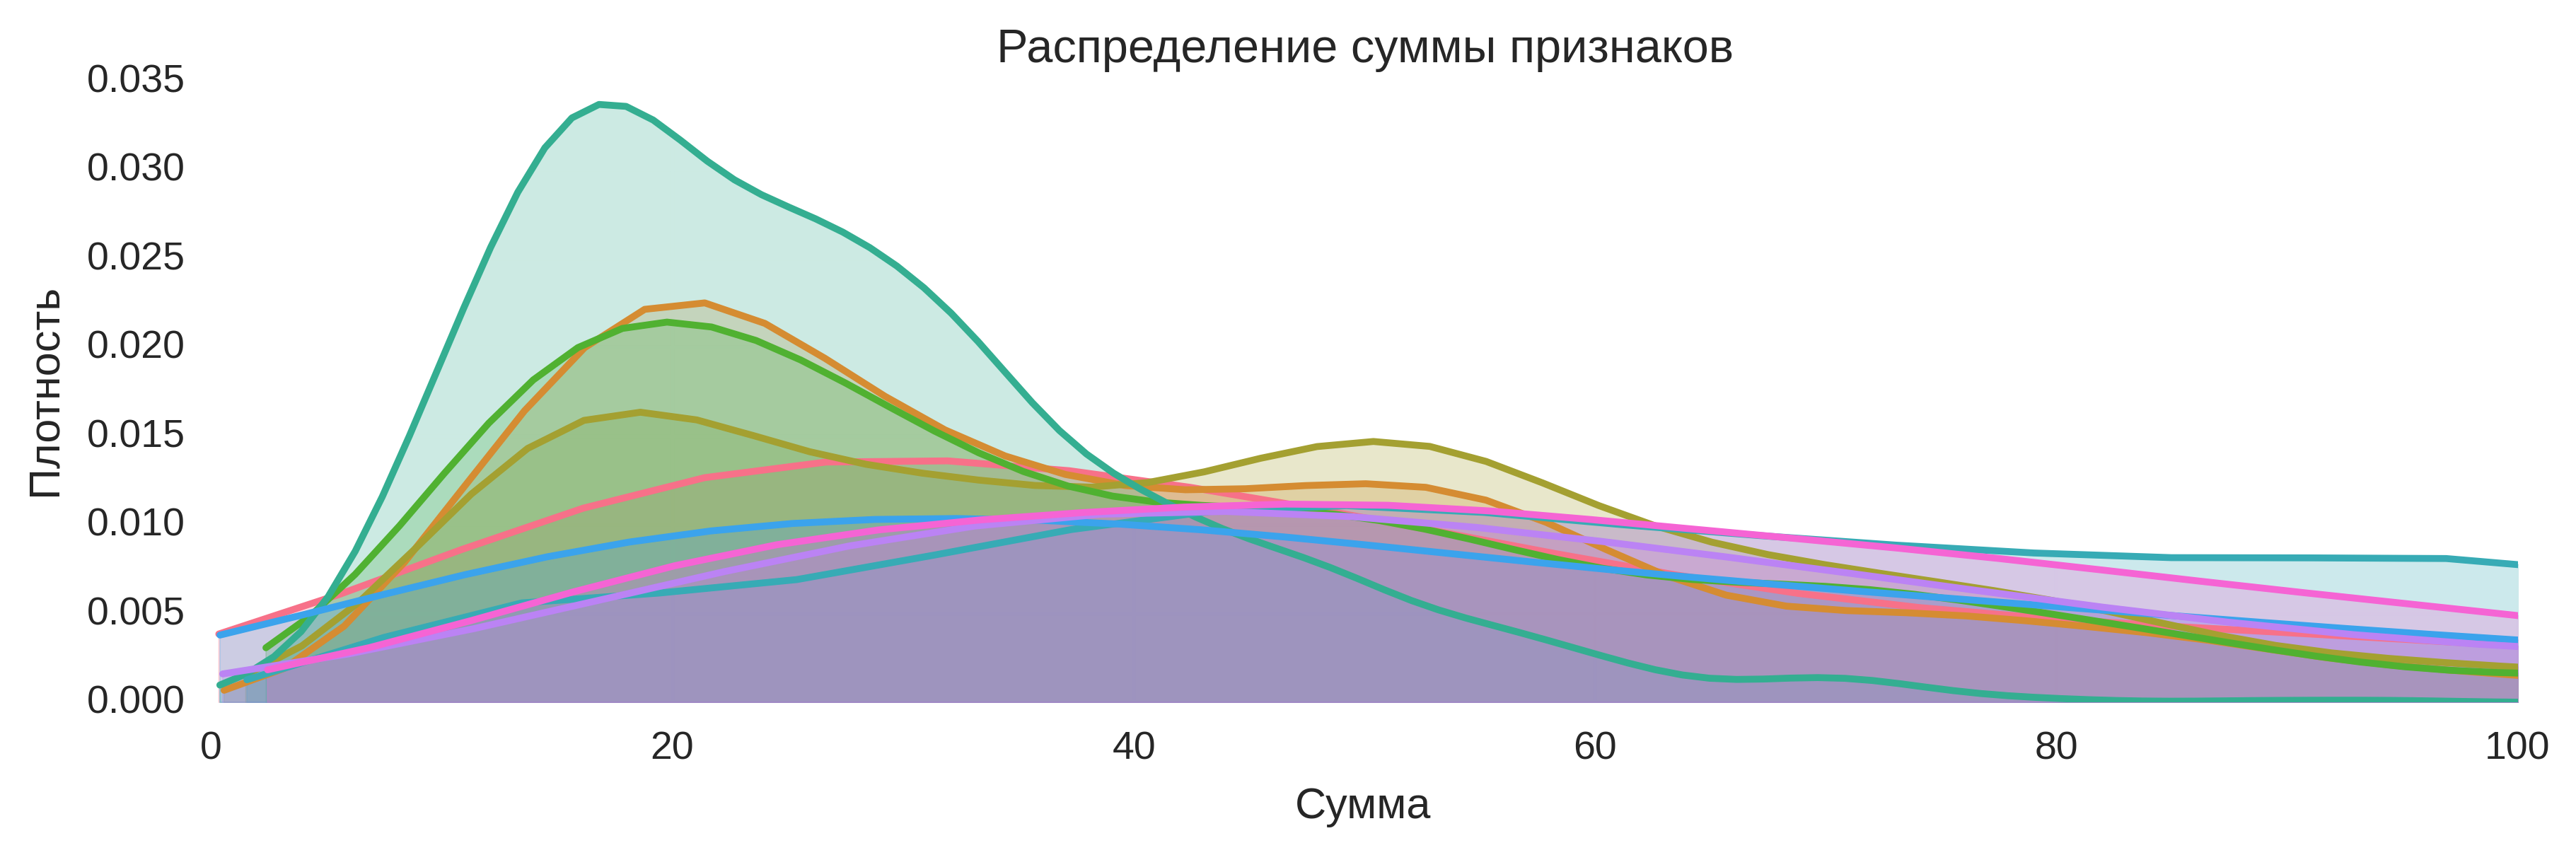

In [6]:
research['f_1'] = np.sum(raw_X, axis=1)
fg = sns.FacetGrid(research, hue="target", aspect=3)
fg.map(sns.kdeplot, "f_1", shade=True)
fg.set_xlabels('Сумма')
fg.set_ylabels('Плотность')
fg.set(title='Распределение суммы признаков')
fg.set(xlim=(0, 100));

##Полезные утилиты

In [7]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import scale

Функция генерирует матрицу признаков. Опциональный параметр позволяет добавить бинарные признаки нулей в исходных данных.

In [8]:
def engineer_features(data_for_X, add_zeroes=False):
    raw_X = data_for_X.values
    
    tfidf = TfidfTransformer()
    X_base = tfidf.fit_transform(raw_X[:,:93]).toarray() #original 93 features
    
    X_engineered = np.empty((raw_X.shape[0], 3))
    X_engineered[:, 0] = np.sum(raw_X, axis=1)
    X_engineered[:, 1] = np.sum(raw_X ** 0.5, axis=1)
    X_engineered[:, 2] = np.sum(raw_X == 0, axis=1)
    X_engineered = scale(X_engineered)
    
    if add_zeroes:
        X_zeroes = np.array(raw_X[:,:93] == 0, dtype=float)
        X_engineered = np.hstack((X_engineered, X_zeroes))
    
    X = np.hstack((X_base, X_engineered))
    return X

In [9]:
X = engineer_features(data_for_X)

Функция, составляющая предсказание для объектов с неизвестным классом.

In [10]:
def produce_submission(prediction_function):
    data = pd.read_csv('test.csv')
    data_for_X = data.copy().drop(['id'], axis=1)
    #prediction
    y_proba = prediction_function(data_for_X)
    #writing results
    columns = ['Class_' + str(i) for i in range(1, 10)]
    submission = pd.DataFrame(y_proba, columns=columns, index = np.arange(1, len(y_proba) + 1))
    submission.to_csv('submission.csv', index_label='id')

Функция строит трёхмерный график с результатами кросс-валидации по DataFrame и двум указанным параметрам.

In [11]:
from mpl_toolkits.mplot3d import axes3d

def plot_scores_from_data_frame(df, first_param, second_param, filter_function = lambda x: x == x):
    df = df[filter_function(df)]
    X, Y = df[first_param].unique(), df[second_param].unique()
    X.sort(), Y.sort()
    X, Y = np.meshgrid(X, Y)
    Z = np.array(X, dtype=float).flatten()
    for i, result in df.iterrows():
        Z[(X.flatten() == result[first_param]) & (Y.flatten() == result[second_param])] = result.score
    Z = Z.reshape(X.shape[0], X.shape[1])
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1)
    ax.set_xlabel(first_param)
    ax.set_ylabel(second_param)
    plt.show()

Функция составляет DataFrame на основе результата кросс-валидации метода GridSearchCV из sсikit-learn.

In [12]:
def get_pandas_scores(grid_scores):
    results = []
    for score in grid_scores:
        result = score[0] #info about grid
        result['score'] = score[1]
        results.append(result)
    results = pd.DataFrame(results)
    return results

# Эксперименты

Проведём исследование эффективности алгоритмов анализа данных из skikit-learn и xgboost для нашей задачи, варьируя параметры.
Для тестирования будем использовать 25% данных.

In [13]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [14]:
from sklearn.cross_validation import StratifiedKFold, ShuffleSplit
from sklearn.metrics import log_loss
from sklearn.grid_search import GridSearchCV
from sklearn import metrics

cv = ShuffleSplit(X.shape[0], n_iter=1, test_size=0.25, random_state=0)
train, test = next(iter(cv))

In [15]:
def grid_search(clf, param_grid, X, y, cv=cv, scoring='log_loss', n_jobs=-1):
    clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring=scoring, refit=False, n_jobs=n_jobs)
    clf.fit(X, y)
    return get_pandas_scores(clf.grid_scores_)

## Logistic regression

Воспользуемся методом логистической регрессии из библиотеки scikit-learn. Подбор наилучших параметров проиллюстрируем на графике с логарифмеческой шкалой параметра.

In [16]:
from sklearn.linear_model import LogisticRegression

In [17]:
param_grid = {
    'C':np.logspace(0, 2.5, 11)
}
clf = LogisticRegression()
scores = grid_search(clf, param_grid, X, y)
scores

C     score
0     1.000000 -0.648163
1     1.778279 -0.644797
2     3.162278 -0.643041
3     5.623413 -0.642156
4    10.000000 -0.641760
5    17.782794 -0.641624
6    31.622777 -0.641620
7    56.234133 -0.641676
8   100.000000 -0.641746
9   177.827941 -0.641807
10  316.227766 -0.641855

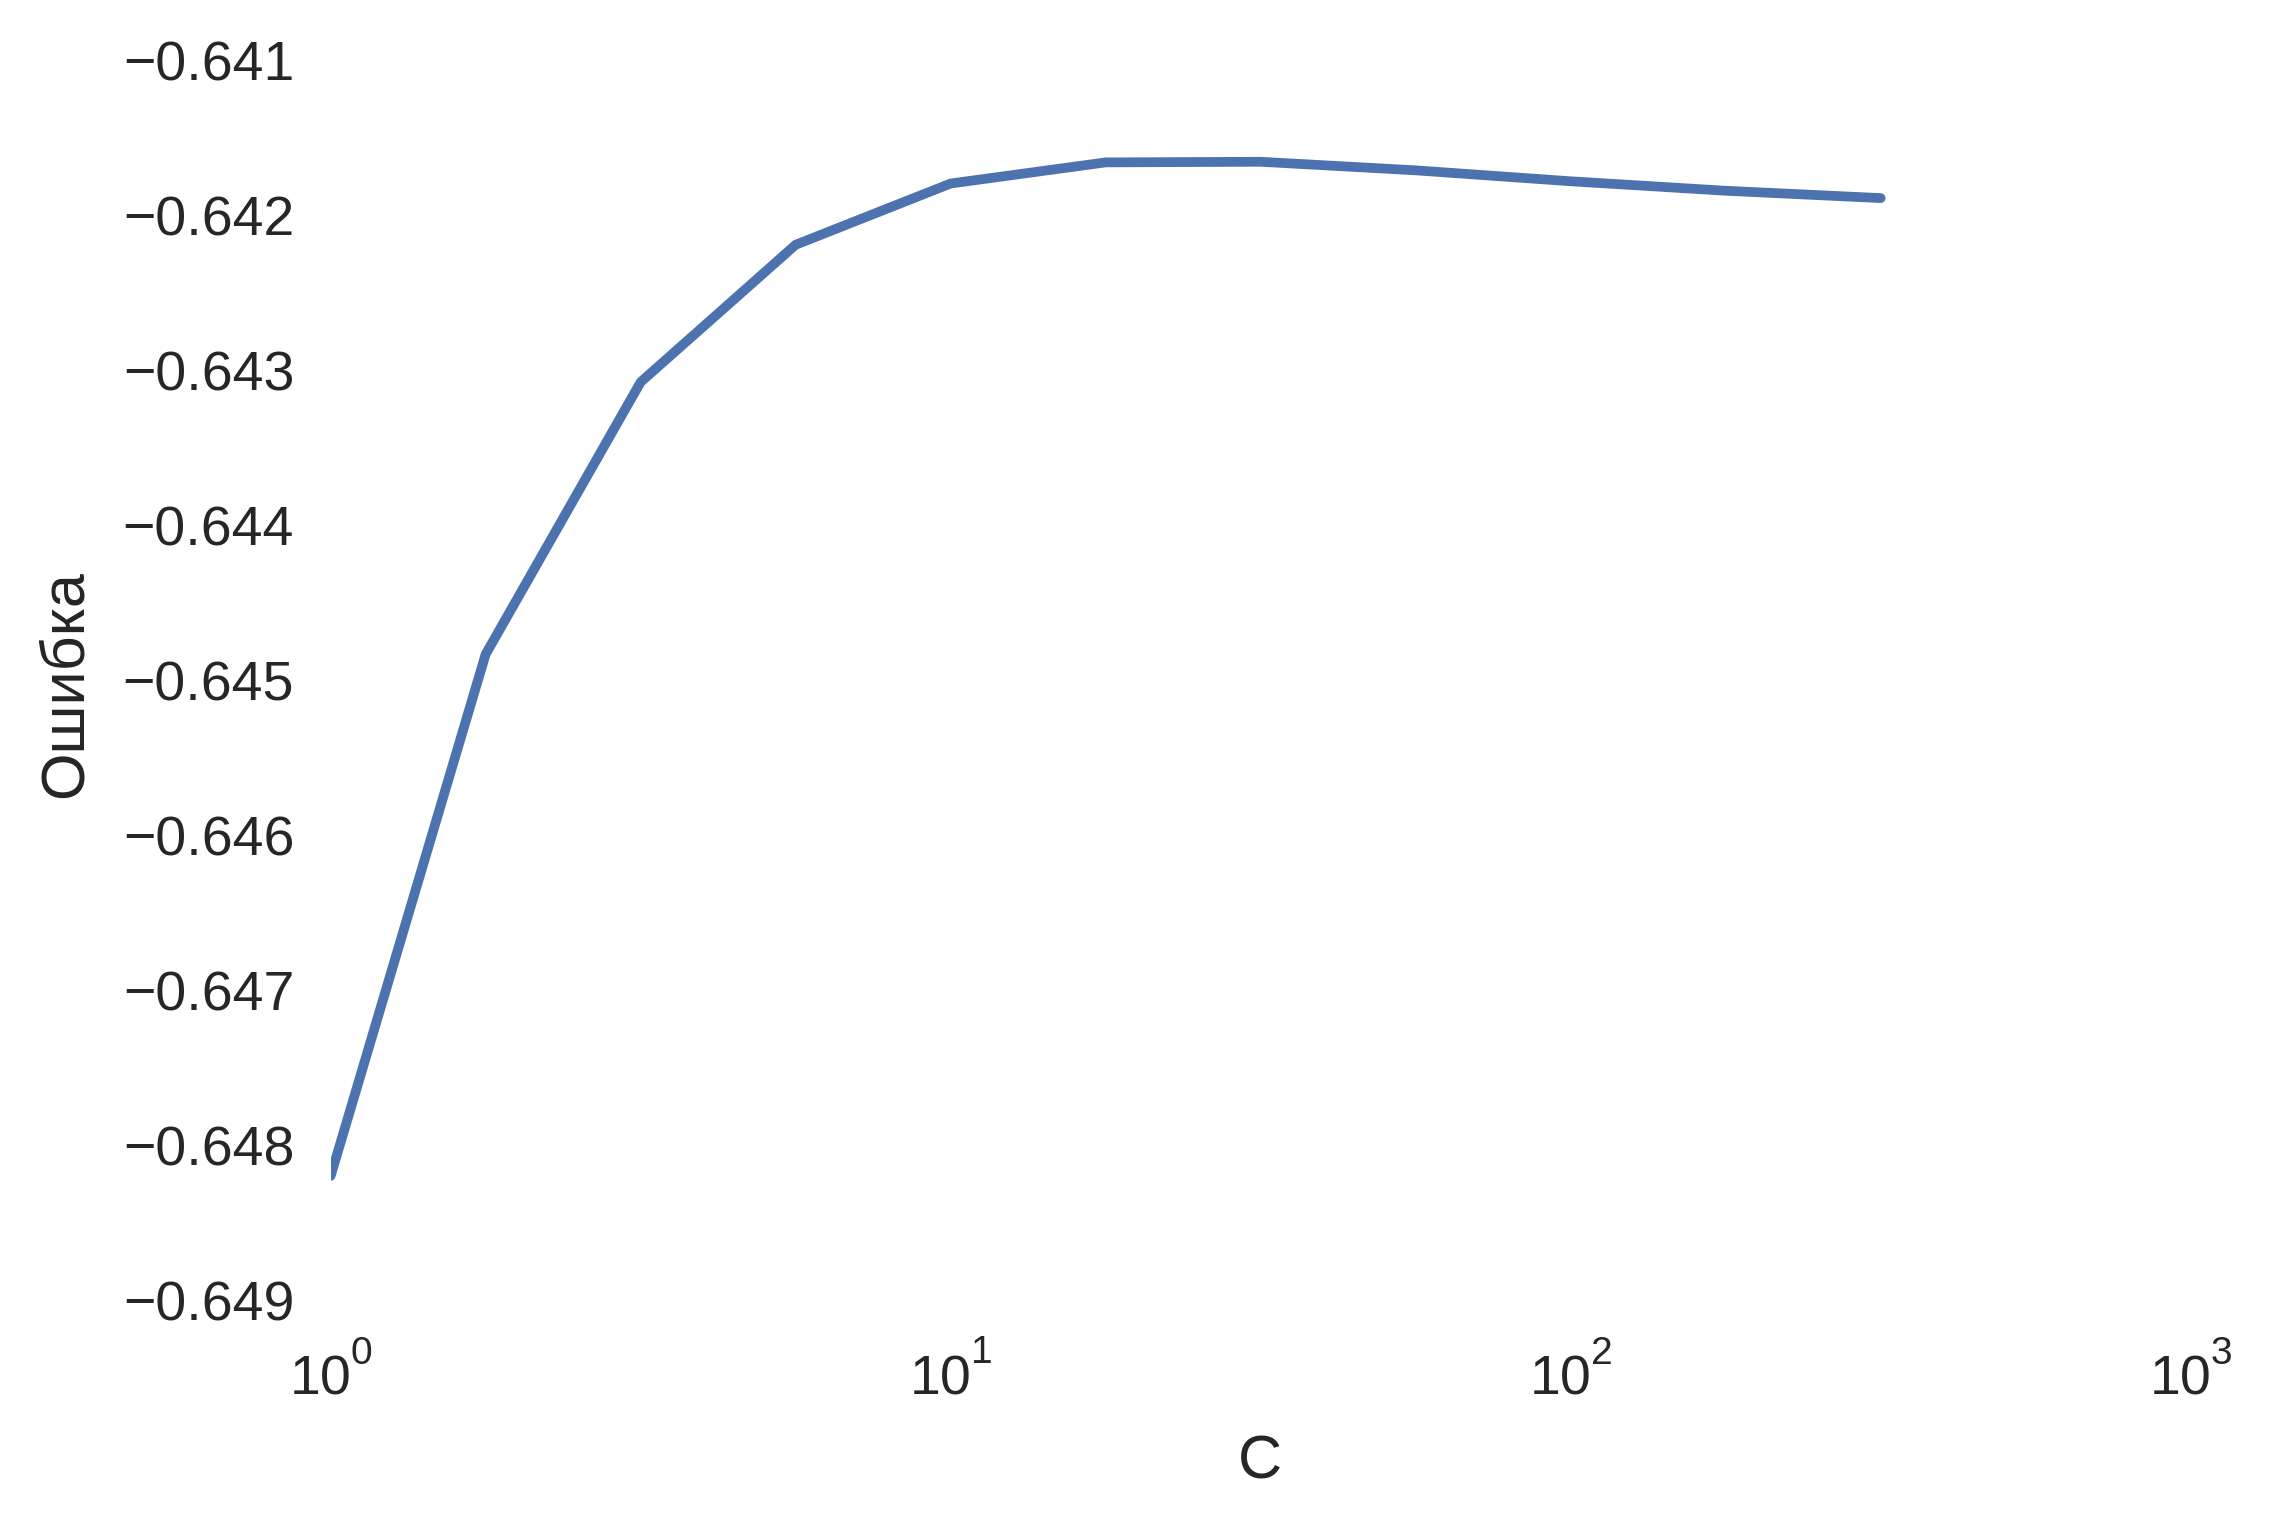

In [18]:
plt.plot(scores['C'], scores['score'])
plt.xlabel('C')
plt.xscale('log')
plt.ylabel('Ошибка')
plt.show()

### С использованием бинарных признаков

Сгенерируем дополнительные признаки.
$$x_{i+93}=\mathbb{I}(x_i=0),\ i=1,...,93$$

In [19]:
scores = grid_search(clf, param_grid, engineer_features(data_for_X, add_zeroes=True), y)
scores

C     score
0     1.000000 -0.612408
1     1.778279 -0.609333
2     3.162278 -0.607728
3     5.623413 -0.606946
4    10.000000 -0.606668
5    17.782794 -0.606637
6    31.622777 -0.606725
7    56.234133 -0.606905
8   100.000000 -0.607121
9   177.827941 -0.607319
10  316.227766 -0.607440

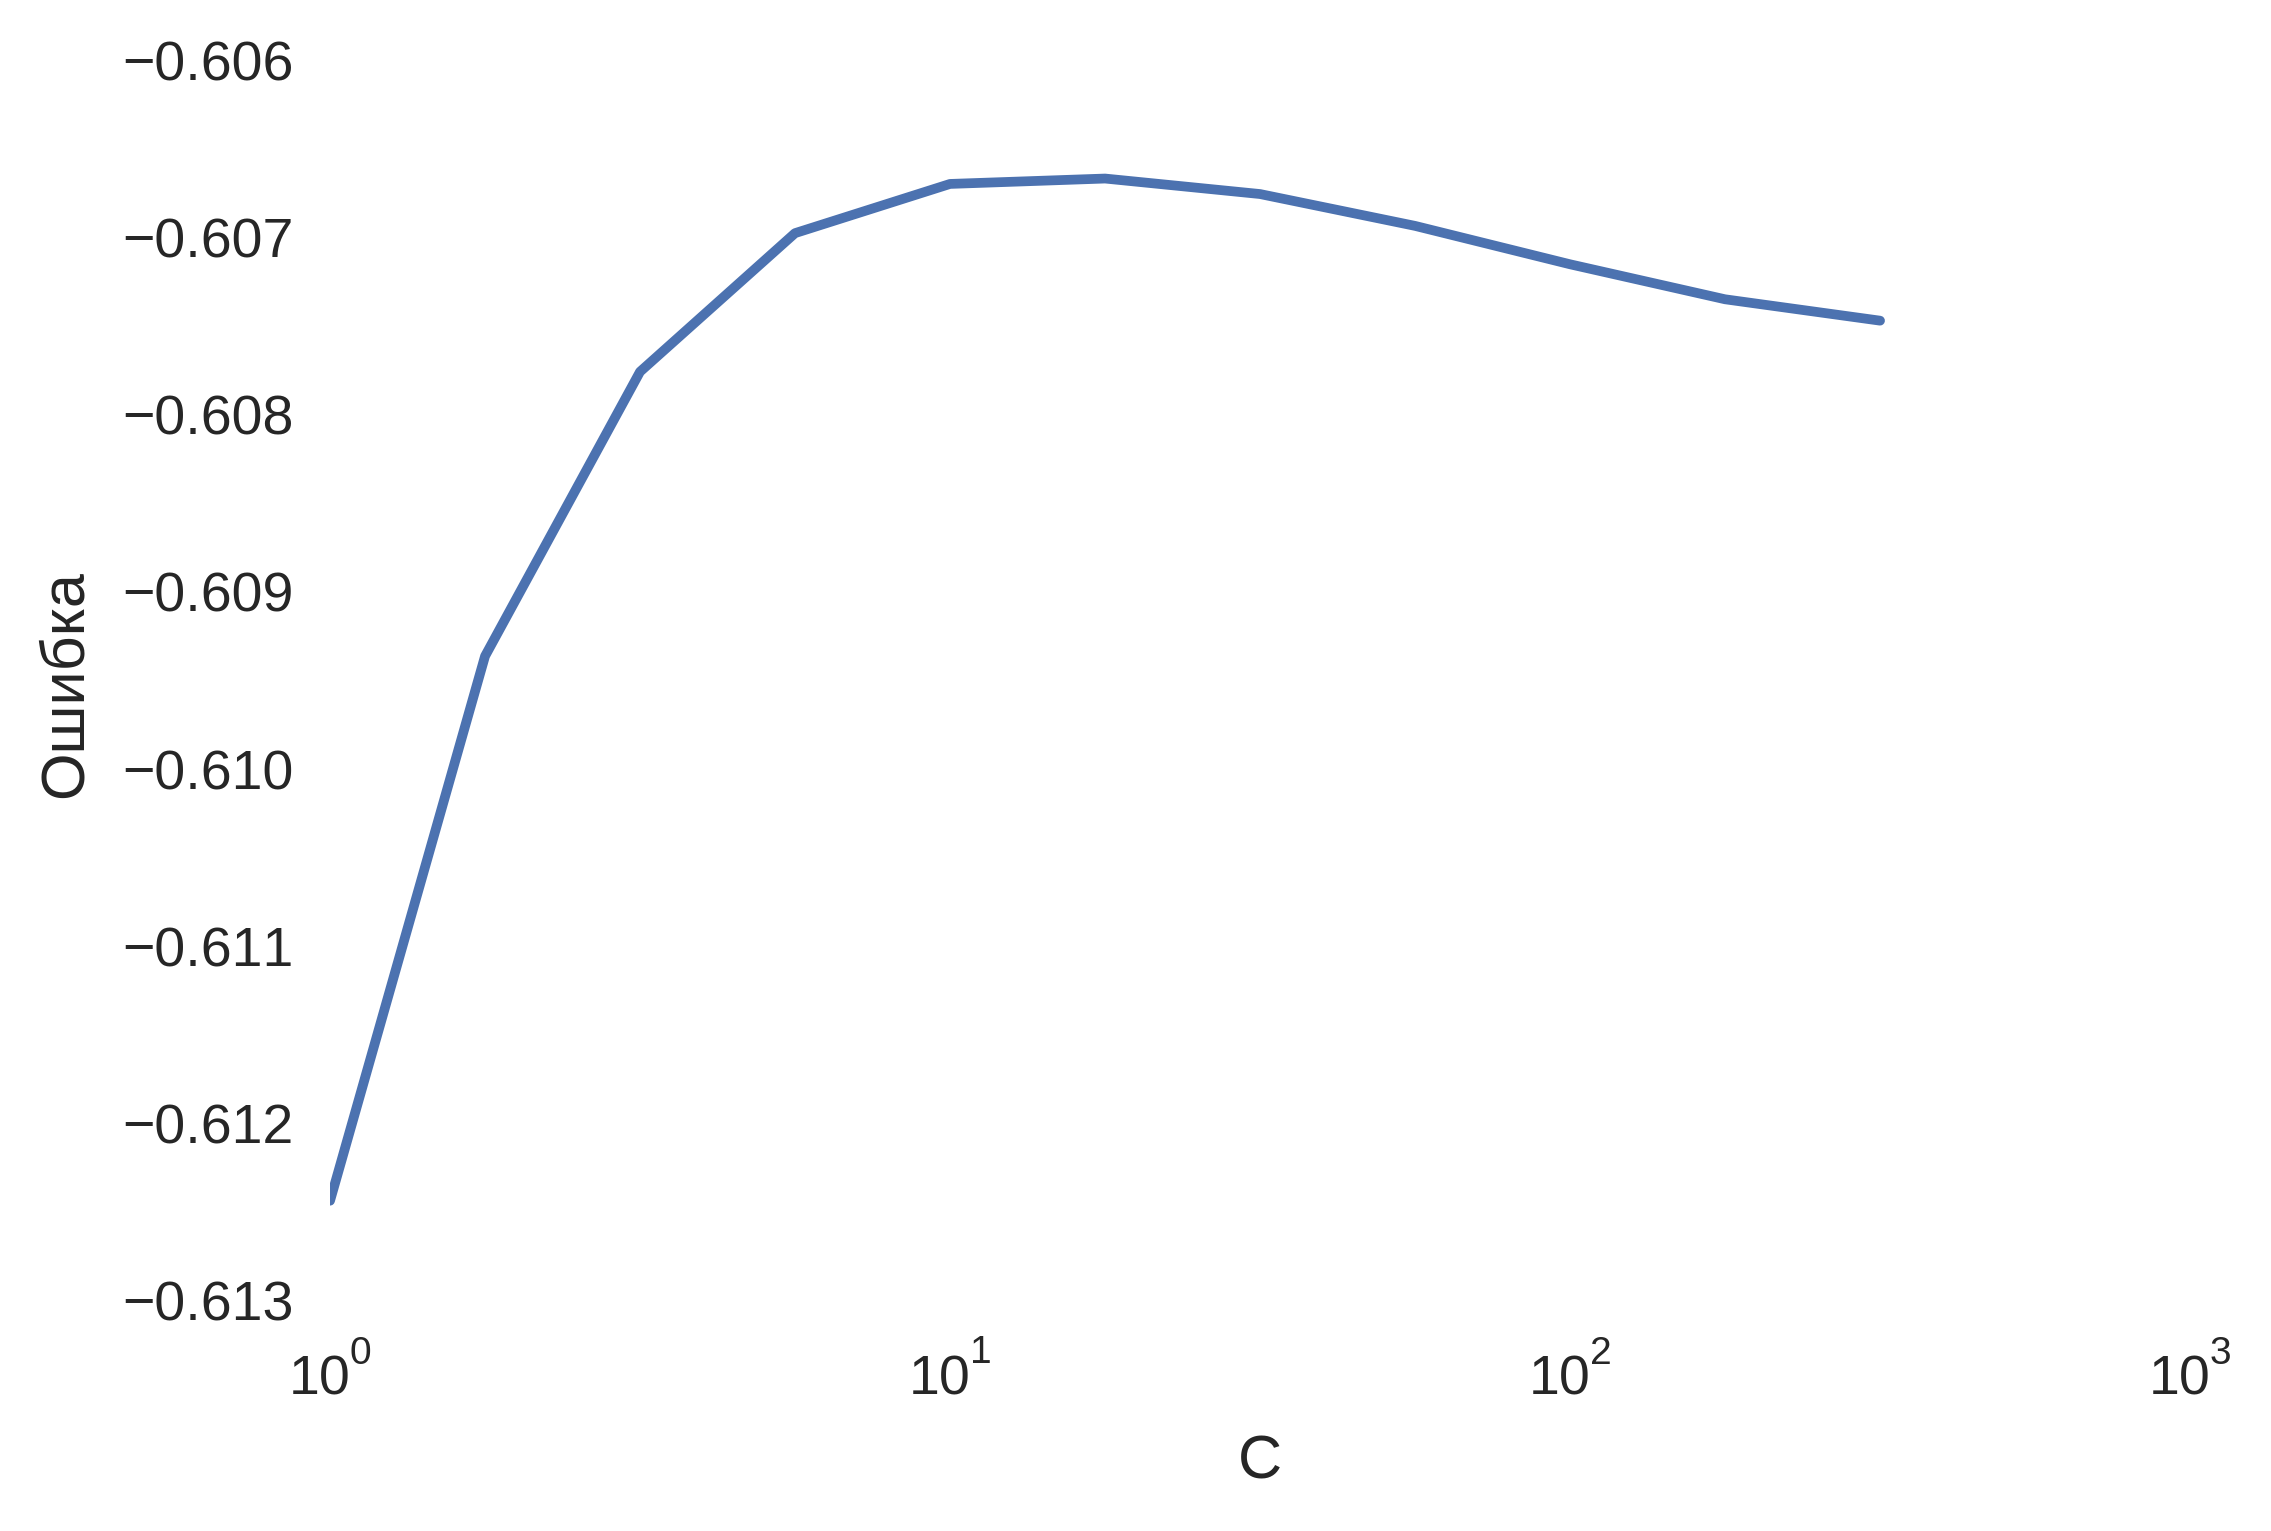

In [20]:
plt.plot(scores['C'], scores['score'])
plt.xlabel('C')
plt.xscale('log')
plt.ylabel('Ошибка')
plt.show()

## Random forest

Применим для нашей задачи метод Random forest из библиотеки scikit-learn, заключающийся в использовании ансамбля решающих деревьев. Каждое решающее дерево состоит из узлов, в которых происходит деление данных на части, а также листьев, в которых записаны итоговые ответы.

Проведем эксперименты при фиксированных числах деревьев для поиска оптимальных параметров метода. Варьировать будем глубину дерева и используемое число признаков в каждом дереве.

In [21]:
%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 250

In [22]:
param_grid = {
    'n_estimators':[128],
    'max_depth':[10, 20, 30],
    'criterion':['entropy', 'gini'],
    'max_features':['sqrt', 'log2']
}

clf = RandomForestClassifier()
scores = grid_search(clf, param_grid, X, y)
scores

criterion  max_depth max_features  n_estimators     score
0    entropy         10         sqrt           128 -0.918724
1    entropy         10         log2           128 -0.966498
2    entropy         20         sqrt           128 -0.645264
3    entropy         20         log2           128 -0.684011
4    entropy         30         sqrt           128 -0.624912
5    entropy         30         log2           128 -0.645078
6       gini         10         sqrt           128 -0.946880
7       gini         10         log2           128 -0.994589
8       gini         20         sqrt           128 -0.664834
9       gini         20         log2           128 -0.698245
10      gini         30         sqrt           128 -0.610710
11      gini         30         log2           128 -0.633242

In [23]:
param_grid = {
    'n_estimators':[64],
    'max_depth':[10, 20, 40, 60],
    'criterion':['gini'],
    'max_features':[10, 30]
}

clf = RandomForestClassifier()
scores = grid_search(clf, param_grid, X, y)
scores

criterion  max_depth  max_features  n_estimators     score
0      gini         10            10            64 -0.936300
1      gini         10            30            64 -0.875990
2      gini         20            10            64 -0.659875
3      gini         20            30            64 -0.621945
4      gini         40            10            64 -0.636702
5      gini         40            30            64 -0.608430
6      gini         60            10            64 -0.651210
7      gini         60            30            64 -0.645035

Результаты проведенных экспериментов иллюстрирует приведенный ниже график зависимости успешности метода в зависимости от глубины деревьев и количества используемых признаков.

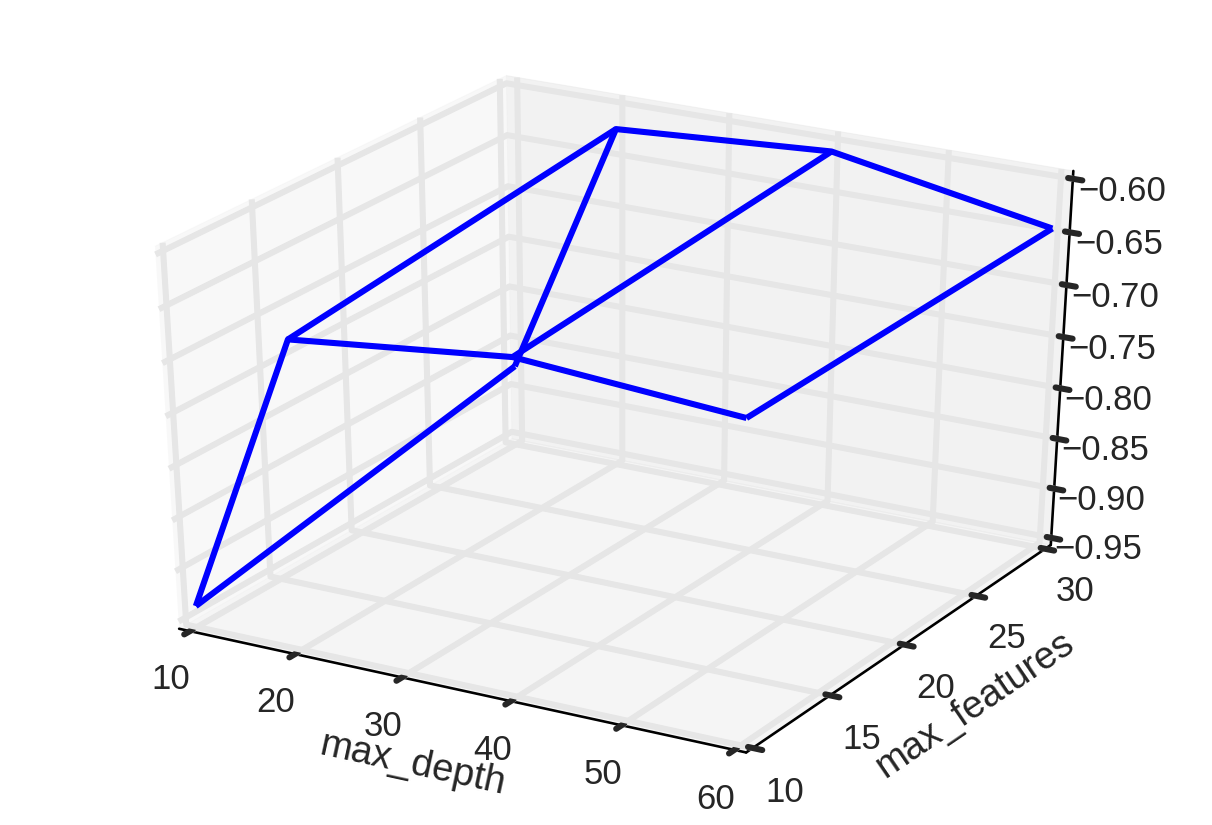

In [24]:
plot_scores_from_data_frame(scores, 'max_depth', 'max_features')

In [25]:
param_grid = {
    'n_estimators':[128],
    'max_depth':[30, 40, 50],
    'criterion':['gini'],
    'max_features':[10, 20, 30, 40, 50]
}

clf = RandomForestClassifier()
scores = grid_search(clf, param_grid, X, y)
scores

criterion  max_depth  max_features  n_estimators     score
0       gini         30            10           128 -0.601325
1       gini         30            20           128 -0.574671
2       gini         30            30           128 -0.576365
3       gini         30            40           128 -0.578276
4       gini         30            50           128 -0.573159
5       gini         40            10           128 -0.602521
6       gini         40            20           128 -0.592359
7       gini         40            30           128 -0.577451
8       gini         40            40           128 -0.588381
9       gini         40            50           128 -0.579980
10      gini         50            10           128 -0.611727
11      gini         50            20           128 -0.602038
12      gini         50            30           128 -0.589470
13      gini         50            40           128 -0.610952
14      gini         50            50           128 -0.605527

Тот же график, но для большего числа деревьев, показывает уже более сложную зависимость.

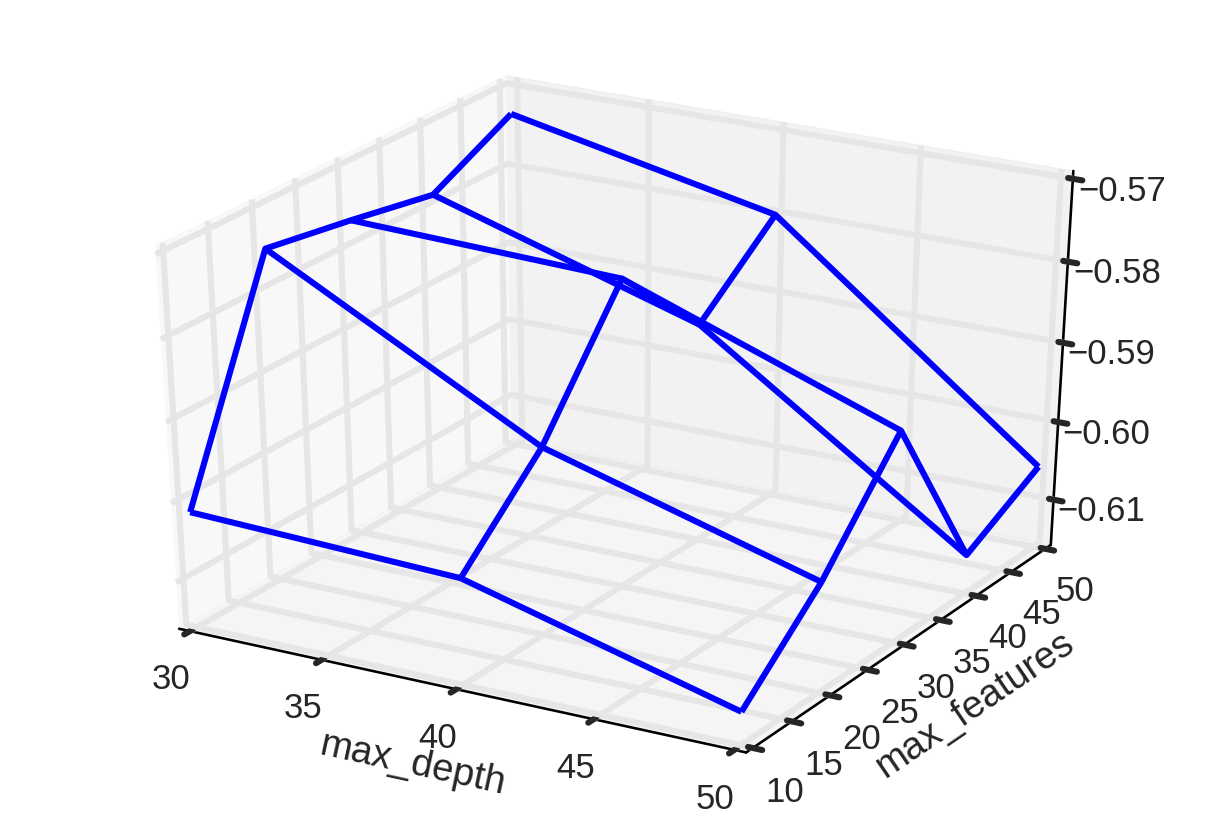

In [26]:
plot_scores_from_data_frame(scores, 'max_depth', 'max_features')

In [27]:
param_grid = {
    'n_estimators':[128],
    'max_depth':[26,  28, 30, 32, 34],
    'criterion':['gini'],
    'max_features':[26,  28, 30, 32, 34]
}

clf = RandomForestClassifier()
scores = grid_search(clf, param_grid, X, y)
scores

criterion  max_depth  max_features  n_estimators     score
0       gini         26            26           128 -0.583130
1       gini         26            28           128 -0.586138
2       gini         26            30           128 -0.583367
3       gini         26            32           128 -0.583591
4       gini         26            34           128 -0.579656
5       gini         28            26           128 -0.577436
6       gini         28            28           128 -0.577155
7       gini         28            30           128 -0.579439
8       gini         28            32           128 -0.576798
9       gini         28            34           128 -0.574293
10      gini         30            26           128 -0.578991
11      gini         30            28           128 -0.576768
12      gini         30            30           128 -0.575733
13      gini         30            32           128 -0.574083
14      gini         30            34           128 -0.574407
15      gini         32            26           128 -0.576483
16      gini         32            28           128 -0.575623
17      gini         32            30           128 -0.577764
18      gini         32            32           128 -0.572449
19      gini         32            34           128 -0.572678
20      gini         34            26           128 -0.575274
21      gini         34            28           128 -0.578018
22      gini         34            30           128 -0.577528
23      gini         34            32           128 -0.577282
24      gini         34            34           128 -0.572827

Для нахождения лучших параметров мы собрали данные в более узкой области.

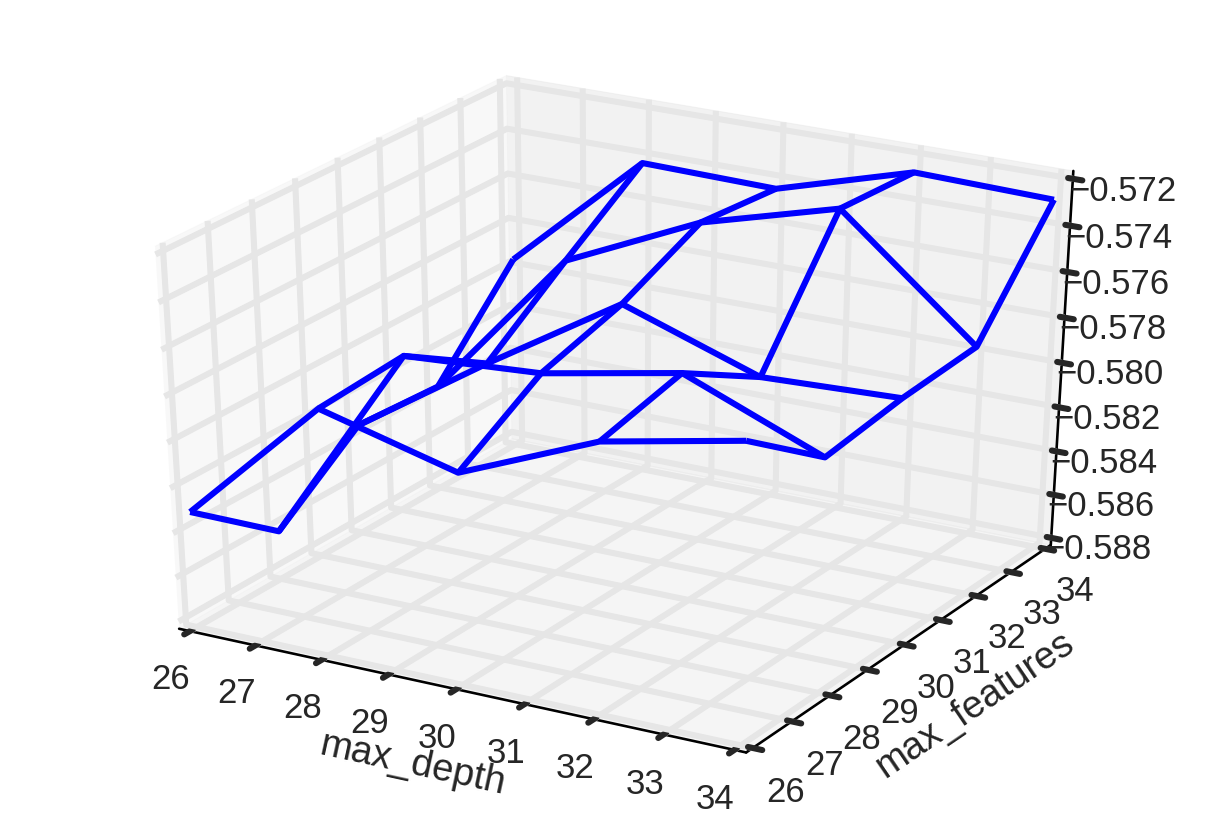

In [28]:
plot_scores_from_data_frame(scores, 'max_depth', 'max_features')

In [29]:

param_grid = {
    'n_estimators':[128],
    'max_depth':[32, 34, 36],
    'criterion':['gini'],
    'max_features':[28, 30, 32]
}

clf = RandomForestClassifier()
scores = grid_search(clf, param_grid, X, y)
scores

criterion  max_depth  max_features  n_estimators     score
0      gini         32            28           128 -0.576613
1      gini         32            30           128 -0.573585
2      gini         32            32           128 -0.569498
3      gini         34            28           128 -0.575335
4      gini         34            30           128 -0.570266
5      gini         34            32           128 -0.575244
6      gini         36            28           128 -0.576379
7      gini         36            30           128 -0.577429
8      gini         36            32           128 -0.574016

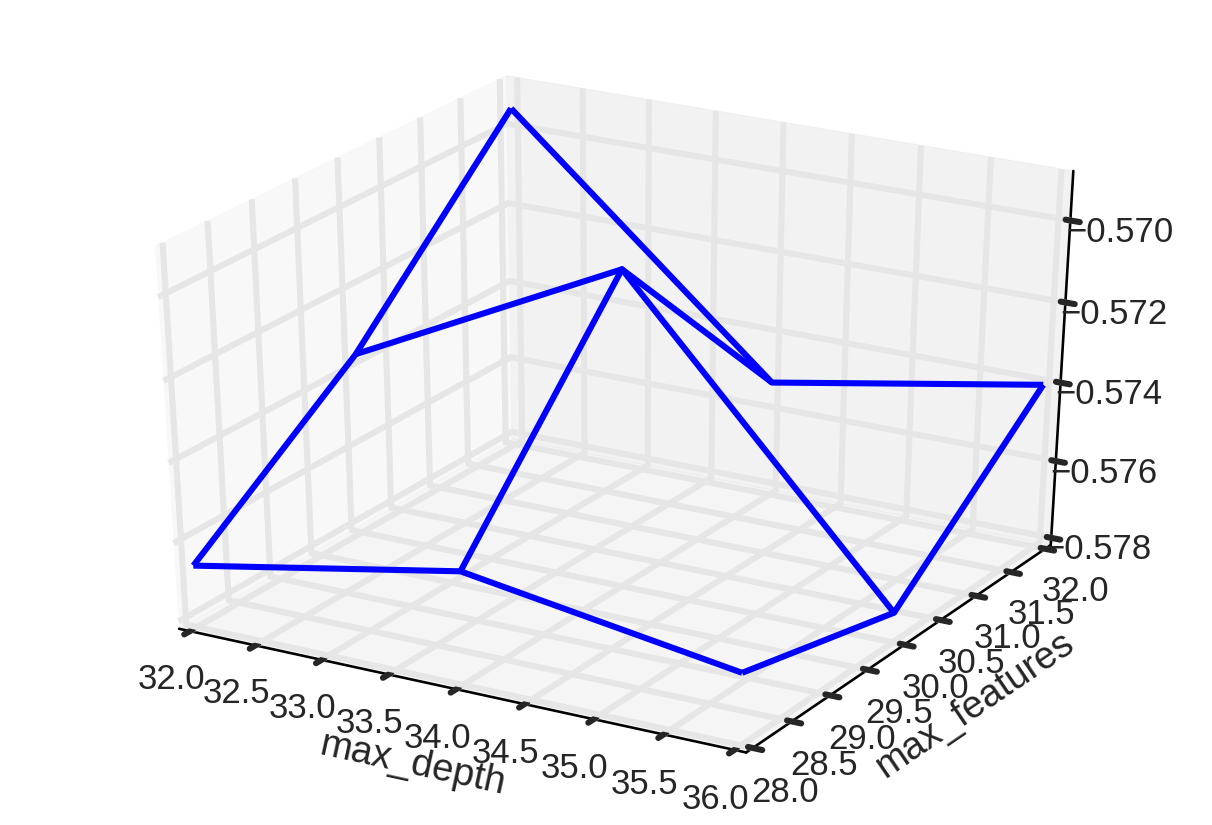

In [30]:
plot_scores_from_data_frame(scores, 'max_depth', 'max_features')

Таким образом, мы нашли подходящие для данного метода параметры: глубина $-$ 34, число признаков $-$ 30.

### Extreme random forest

Повторим теперь ту же процедуру, что была проделана выше, для метода Extra trees classifier из библиотеки scikit-learn. Основное отличие этого метода от предыдущего в том, что он делает разбиение узлов в деревьях решений случайным образом, а не оптимизируя количество соответствующей информации.

In [31]:
param_grid = {
    'n_estimators':[128],
    'max_depth':[40, 50, 60, 70],
    'max_features':[40, 50, 60],
    'criterion':['gini'],
}

clf = ExtraTreesClassifier()
scores = grid_search(clf, param_grid, X, y)
scores

criterion  max_depth  max_features  n_estimators     score
0       gini         40            40           128 -0.544525
1       gini         40            50           128 -0.547358
2       gini         40            60           128 -0.536818
3       gini         50            40           128 -0.556809
4       gini         50            50           128 -0.566489
5       gini         50            60           128 -0.544268
6       gini         60            40           128 -0.570222
7       gini         60            50           128 -0.564706
8       gini         60            60           128 -0.565052
9       gini         70            40           128 -0.573903
10      gini         70            50           128 -0.576355
11      gini         70            60           128 -0.576622

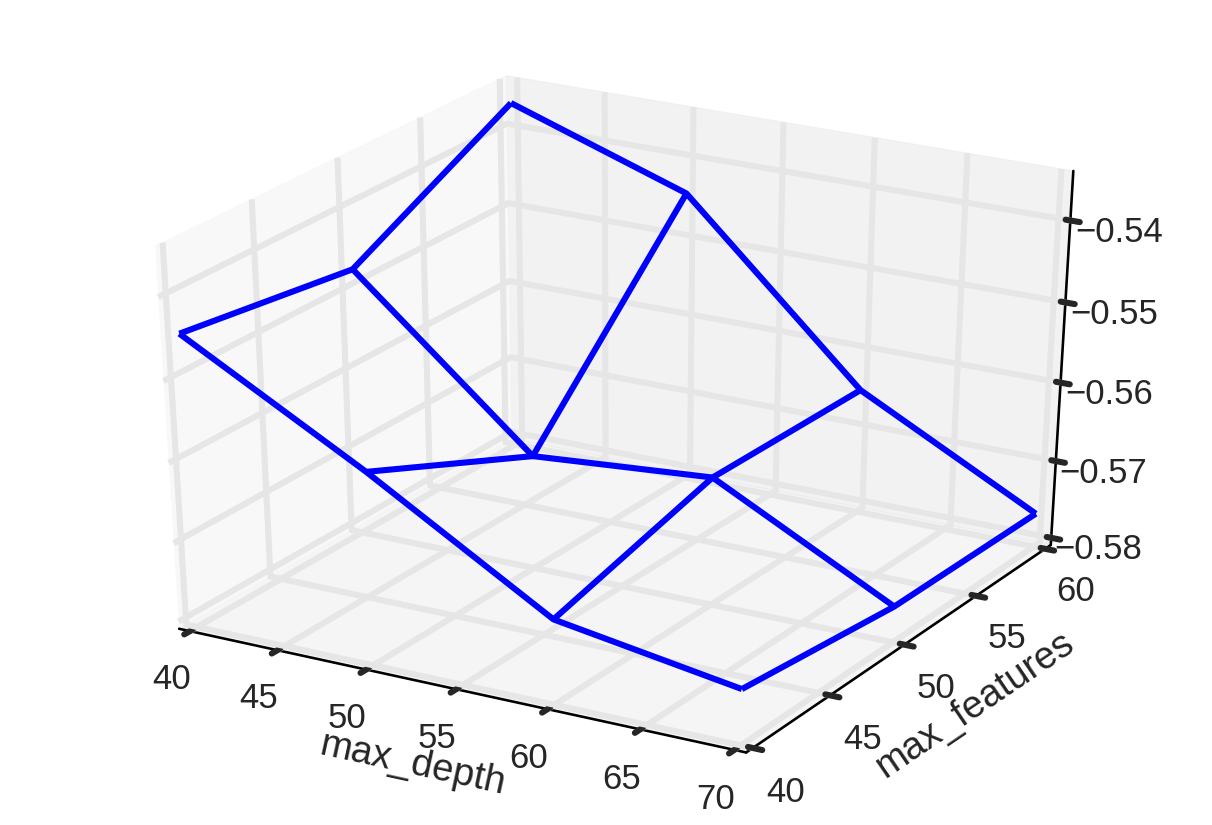

In [32]:
plot_scores_from_data_frame(scores, 'max_depth', 'max_features')

In [33]:
param_grid = {
    'n_estimators':[128],
    'max_depth':[35, 40, 45],
    'max_features':[60, 70, 80, 90],
    'criterion':['gini'],
    #'bootstrap':[True]
}

clf = ExtraTreesClassifier()
scores = grid_search(clf, param_grid, X, y)
scores

criterion  max_depth  max_features  n_estimators     score
0       gini         35            60           128 -0.539639
1       gini         35            70           128 -0.540939
2       gini         35            80           128 -0.544651
3       gini         35            90           128 -0.541437
4       gini         40            60           128 -0.536818
5       gini         40            70           128 -0.540956
6       gini         40            80           128 -0.542129
7       gini         40            90           128 -0.540221
8       gini         45            60           128 -0.540434
9       gini         45            70           128 -0.549439
10      gini         45            80           128 -0.542524
11      gini         45            90           128 -0.545390

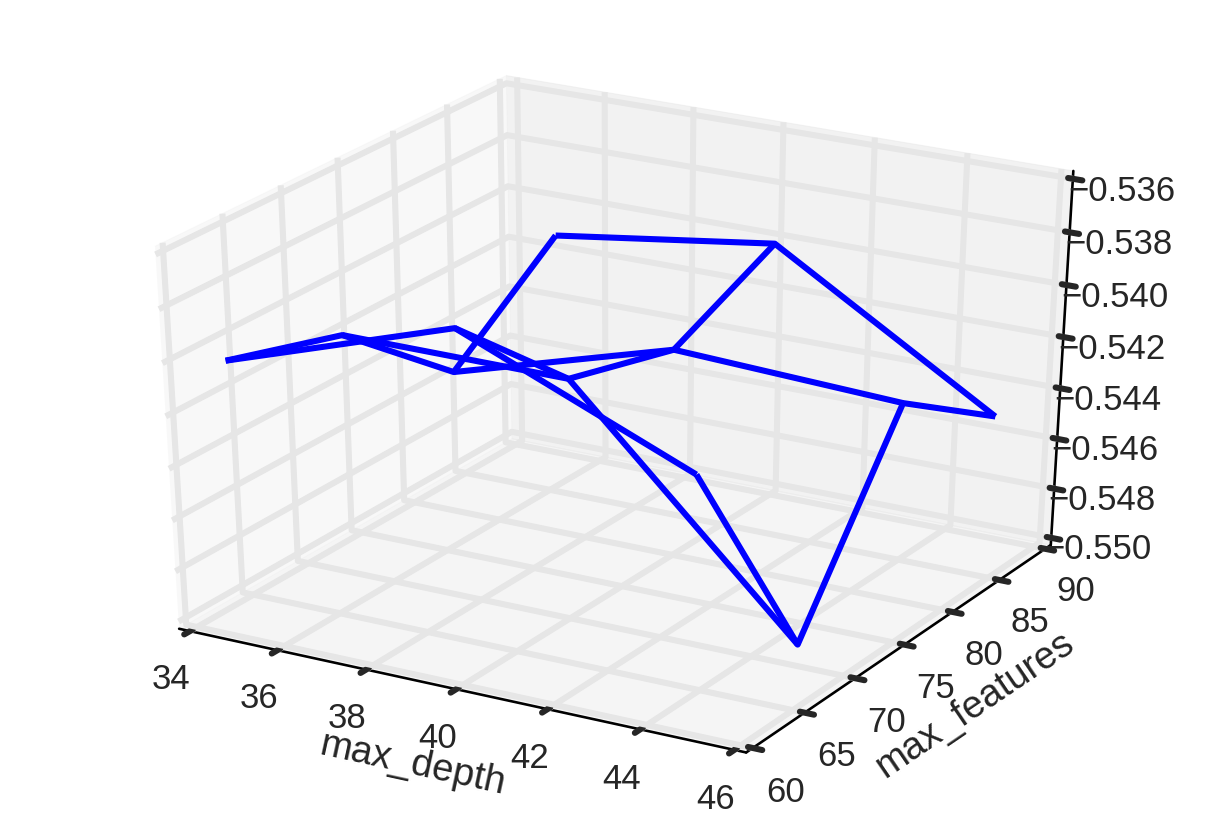

In [34]:
plot_scores_from_data_frame(scores, 'max_depth', 'max_features')

In [41]:
param_grid = {
    'n_estimators':[128],
    'max_depth':[35, 40, 45],
    'max_features':[55, 60, 65],
    'criterion':['gini'],
}

clf = ExtraTreesClassifier()
scores = grid_search(clf, param_grid, X, y)
scores

criterion  max_depth  max_features  n_estimators     score
0      gini         35            55           128 -0.544923
1      gini         35            60           128 -0.545383
2      gini         35            65           128 -0.539393
3      gini         40            55           128 -0.543265
4      gini         40            60           128 -0.536341
5      gini         40            65           128 -0.542060
6      gini         45            55           128 -0.552155
7      gini         45            60           128 -0.545940
8      gini         45            65           128 -0.547249

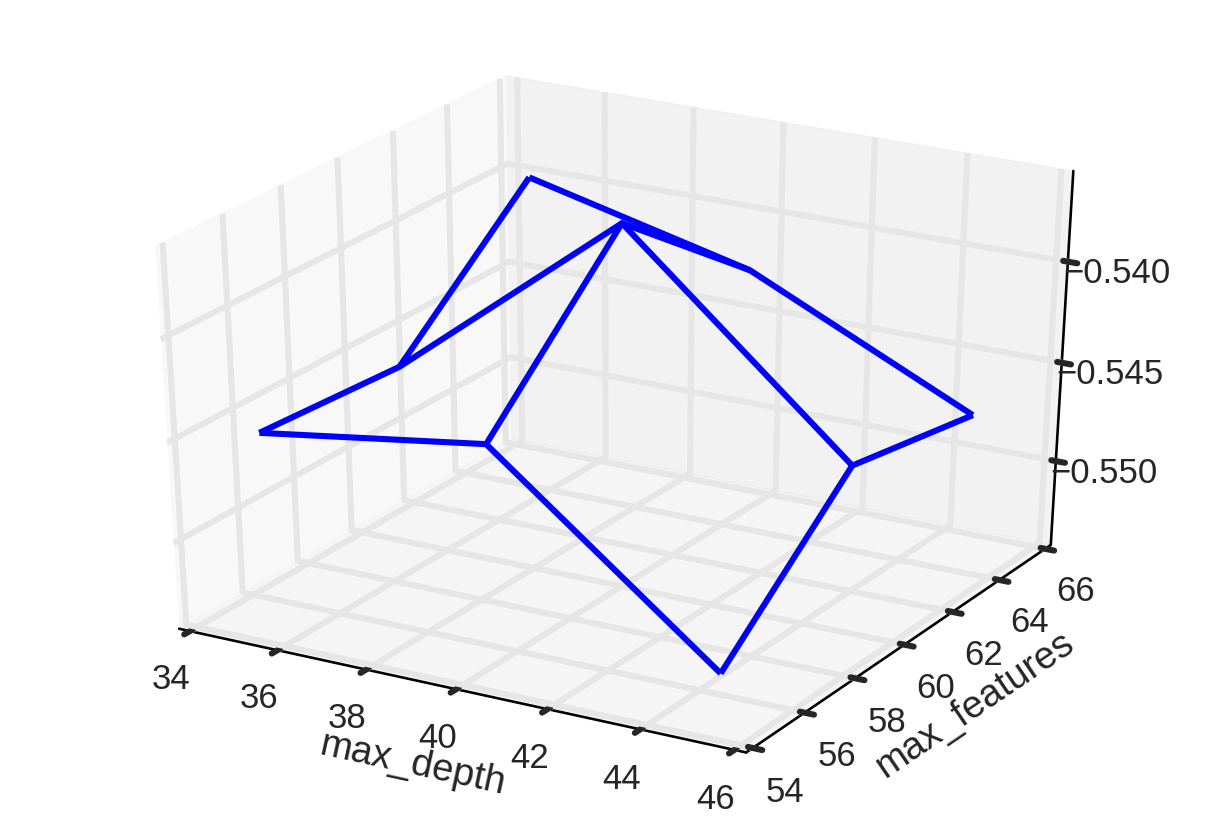

In [42]:
plot_scores_from_data_frame(scores, 'max_depth', 'max_features')

In [43]:
clf = ExtraTreesClassifier(max_depth=40, max_features=60, n_estimators=0, warm_start=True, n_jobs=-1)
l = []
for i in range(40):
    clf.n_estimators += 8
    clf.fit(X[train], y[train])
    result = log_loss(y[test], clf.predict_proba(X[test]))
    l.append(result)

Приведем также анализ зависимости успешности метода ERF в зависимости от числа деревьев. Как это видно ниже, точность постоянно увеличивается с резкими скачками до определенного момента, а потом выходит на почти постоянный уровень.

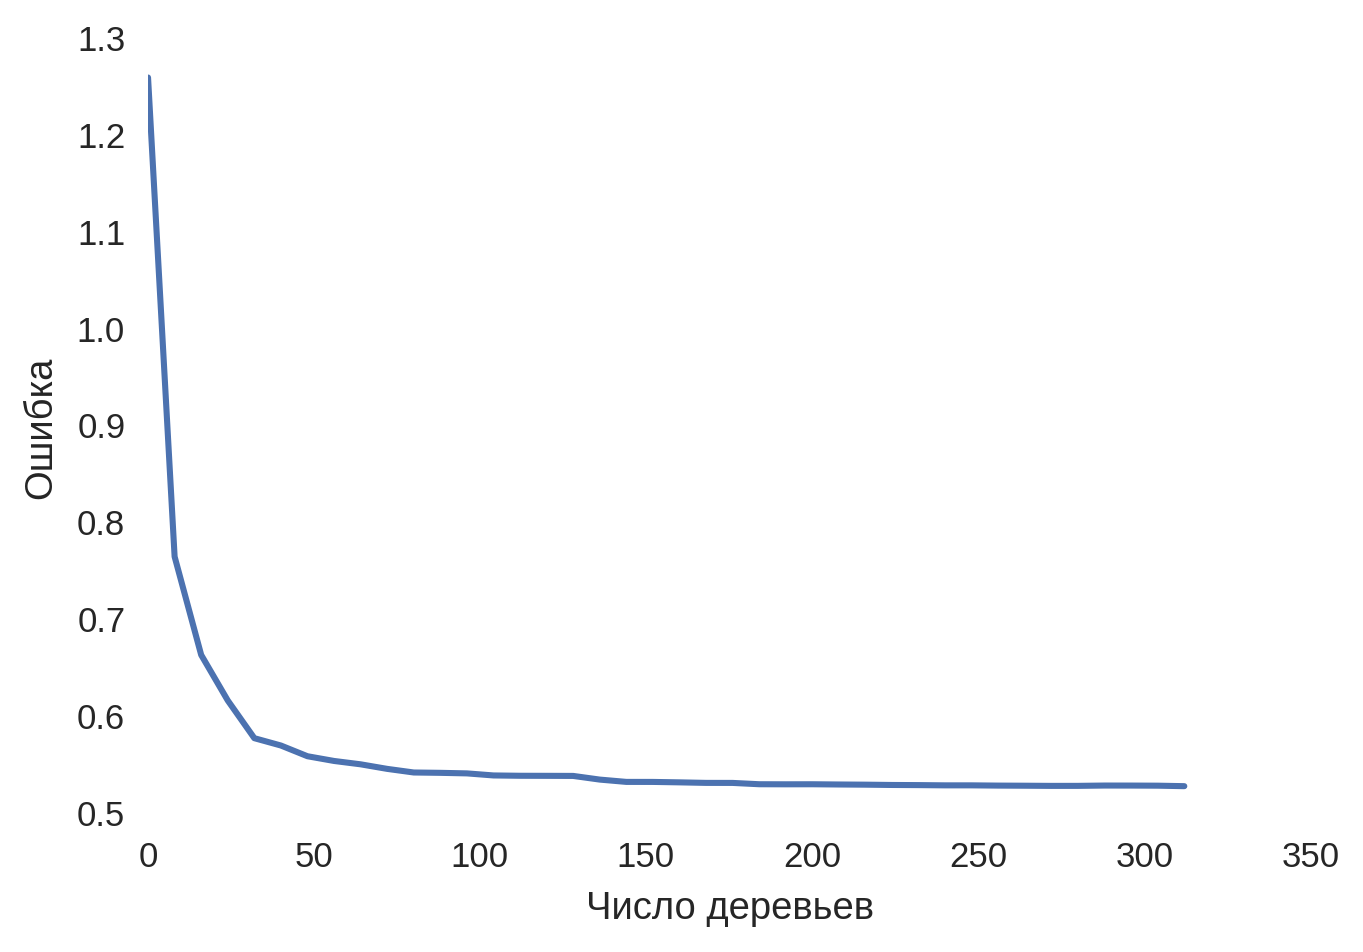

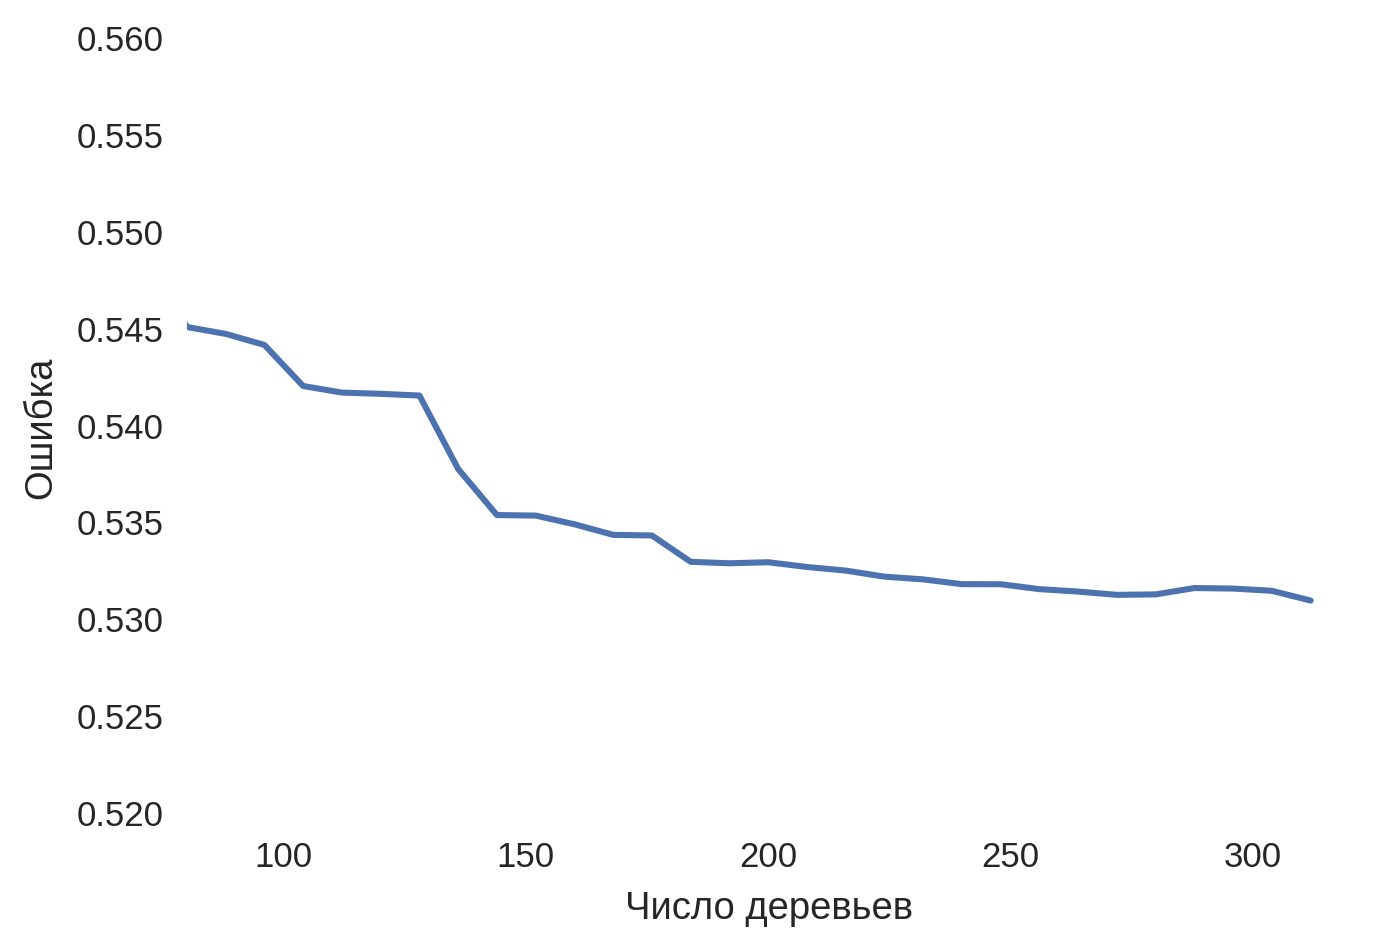

In [44]:
plt.plot([8 * i for i in range(40)], l)
plt.xlabel('Число деревьев')
plt.ylabel('Ошибка')
plt.show()

plt.plot([8 * i for i in range(40)], l)
plt.xlim((10 * 8, 40 * 8))
plt.ylim((0.52, 0.56))
plt.xlabel('Число деревьев')
plt.ylabel('Ошибка')
plt.show()

Таким образом, мы нашли подходящие для данного метода параметры: глубина $-$ 40, число признаков $-$ 60.

### Ada boost

Переходим теперь к методу Adaptive boosting. Основная идея всех бустингов это объединение простых классификаторов для создания одного сильного. Метод Ada boost использует для этого методы, которые немногим сильнее простого угадывания, например, небольшие деревья. Стартуя с модели, в которой каждый простой метод имеет вес $\frac{1}{N}$, метод пытается найти оптимальные веса $w_1,...,w_n$.

Соберем данные по точности метода в зависимости от параметра - точности простых методов. Число простых классификаторов будем держать постоянным - 256.

In [46]:
learning_rates = np.logspace(-4, -1, 10)
param_grid = {
    'n_estimators':[256],
    'learning_rate': learning_rates
}
clf = AdaBoostClassifier()
scores = grid_search(clf, param_grid, X, y)

Полученные данные переносим на график.

learning_rate  n_estimators     score
0       0.000100           256 -1.798134
1       0.000215           256 -1.798164
2       0.000464           256 -1.726356
3       0.001000           256 -1.674500
4       0.002154           256 -1.675413
5       0.004642           256 -1.718606
6       0.010000           256 -1.810928
7       0.021544           256 -1.914924
8       0.046416           256 -1.999266
9       0.100000           256 -2.058341

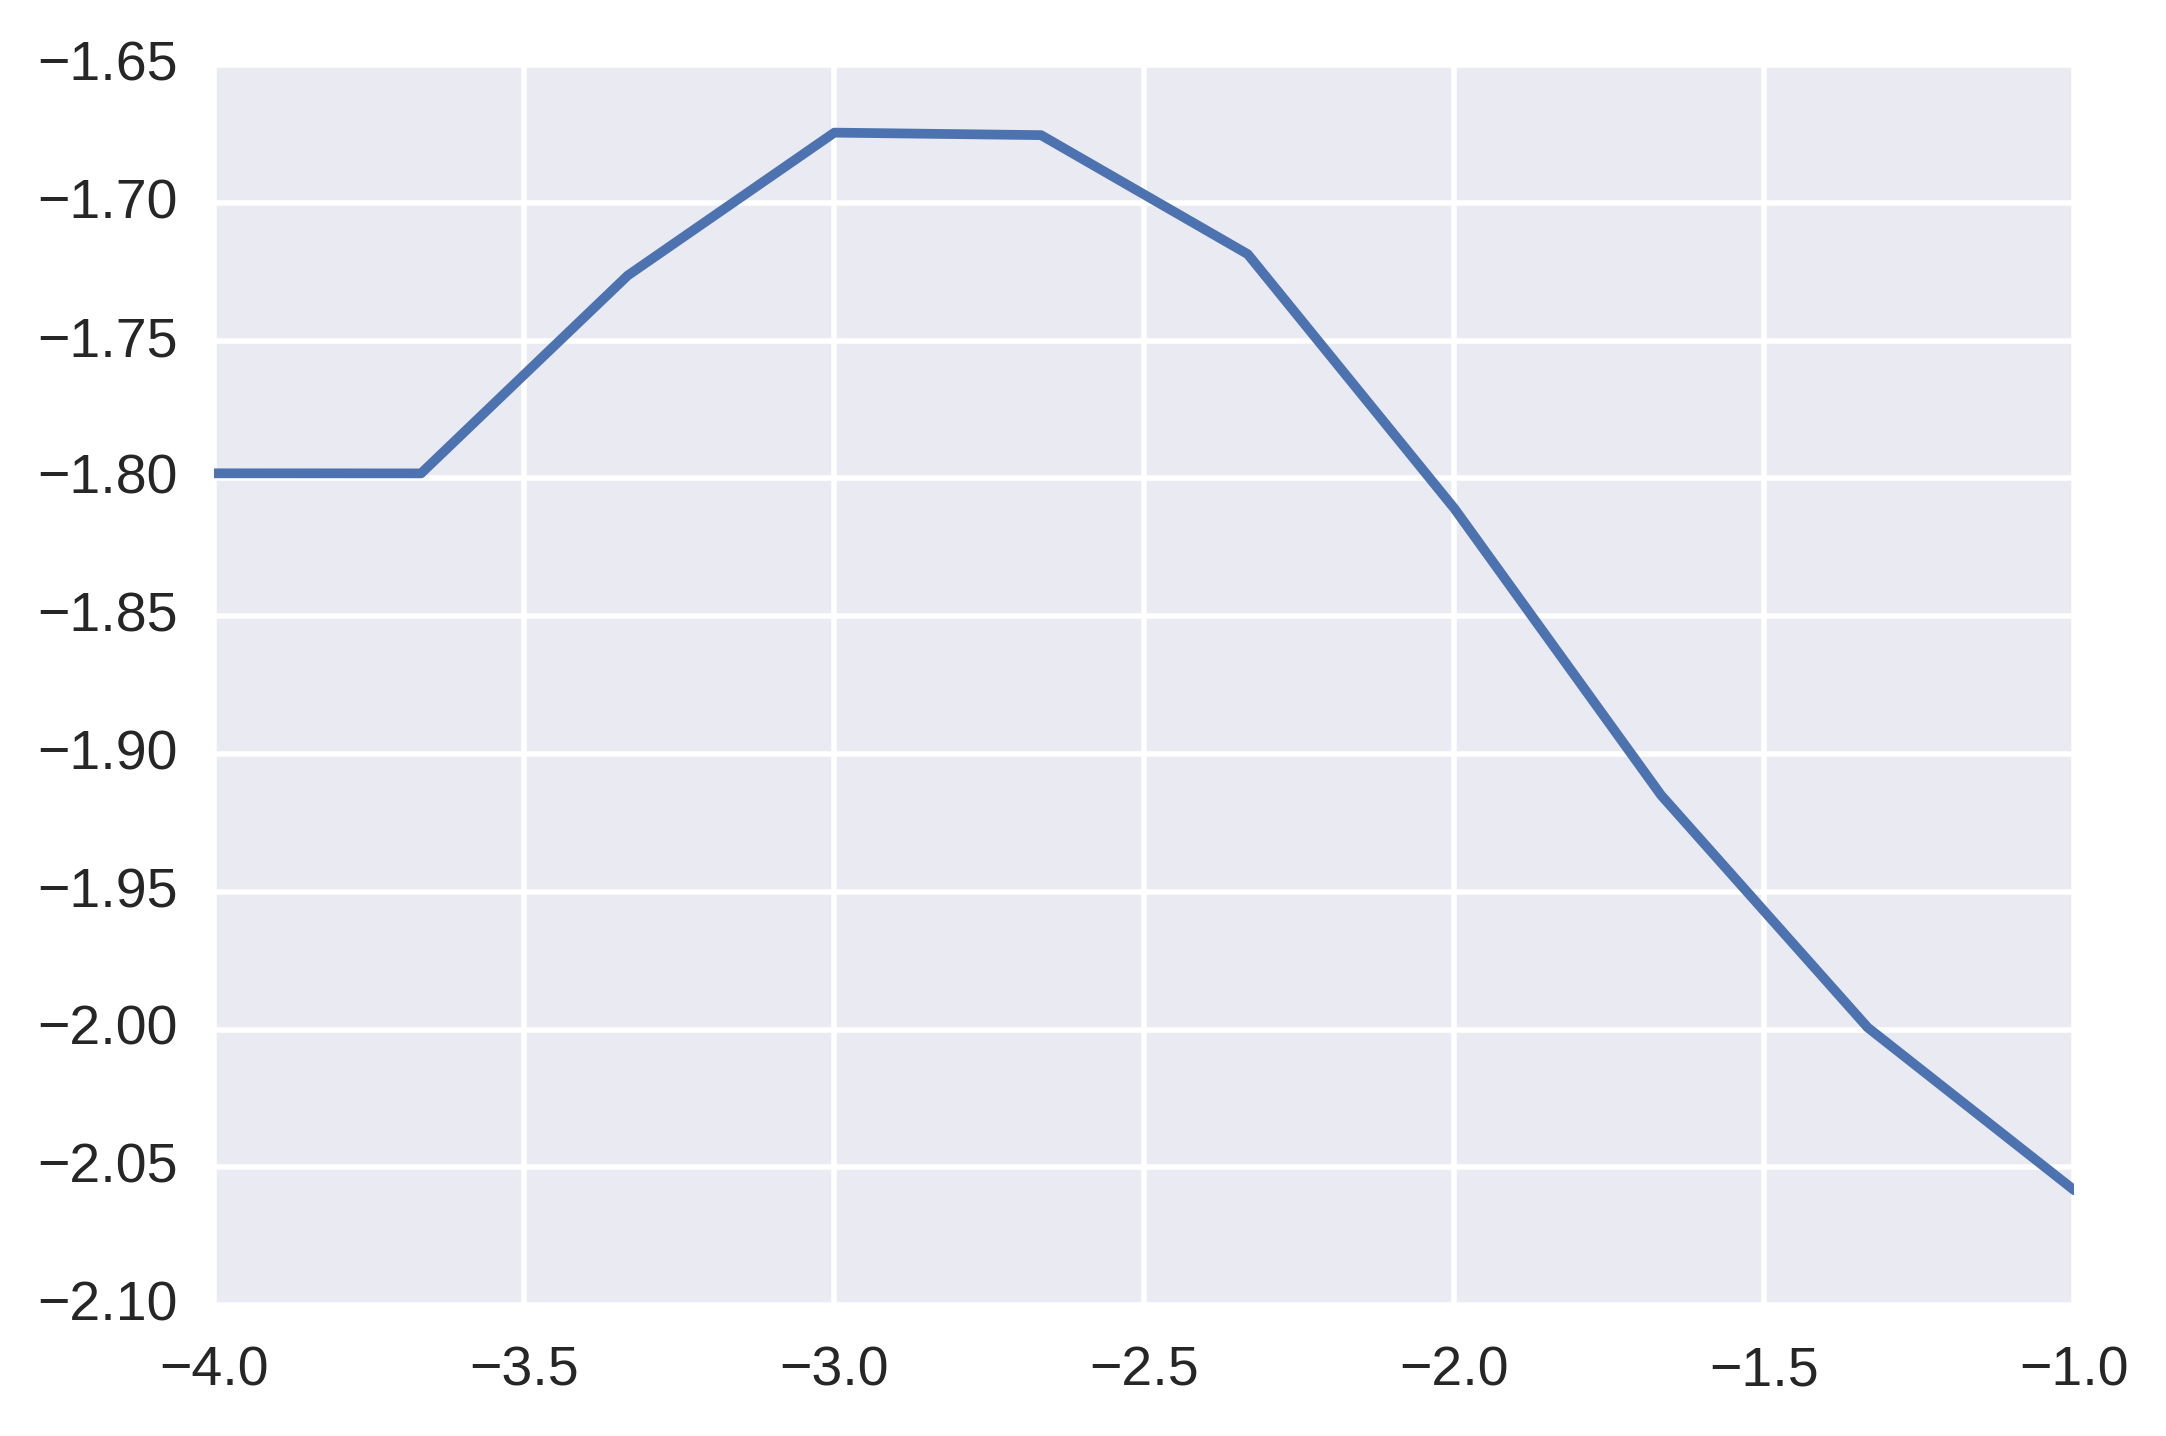

In [47]:
%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 400
plt.plot(learning_rates, scores.score)
plt.xscale('log')
plt.xlabel('learning rate')
plt.ylabel('Ошибка')
scores

### Gradient boosting

Метод Adaboost дал результат хуже, чем методы деревьев. Но другие методы бустинга могут оказаться эффективнее.
Метод Gradient boosting пытается минимизировать некоторую дифференциируемую функцию потерь $L$, то есть аппроксимировать функцию $F^*=\underset{F}{\arg\min}\Bbb E_{x,y}[L(y,F(x))]$. Аппроксимация производится функциями $h_i(x)$ из какого-нибудь класса $\mathcal{H}$:
$$F(x)=\sum\limits_{i=1}^M \gamma_i h_i(x)+const$$
Проведем поиск оптимальных параметров - глубины деревьев и числа признаков.

In [51]:
param_grid = {
    'n_estimators':[64],
    'learning_rate':[0.1],
    'max_depth':[8, 12, 16],
    'max_features':[20, 40, 60, 80]

}
clf = GradientBoostingClassifier()
scores = grid_search(clf, param_grid, X, y)

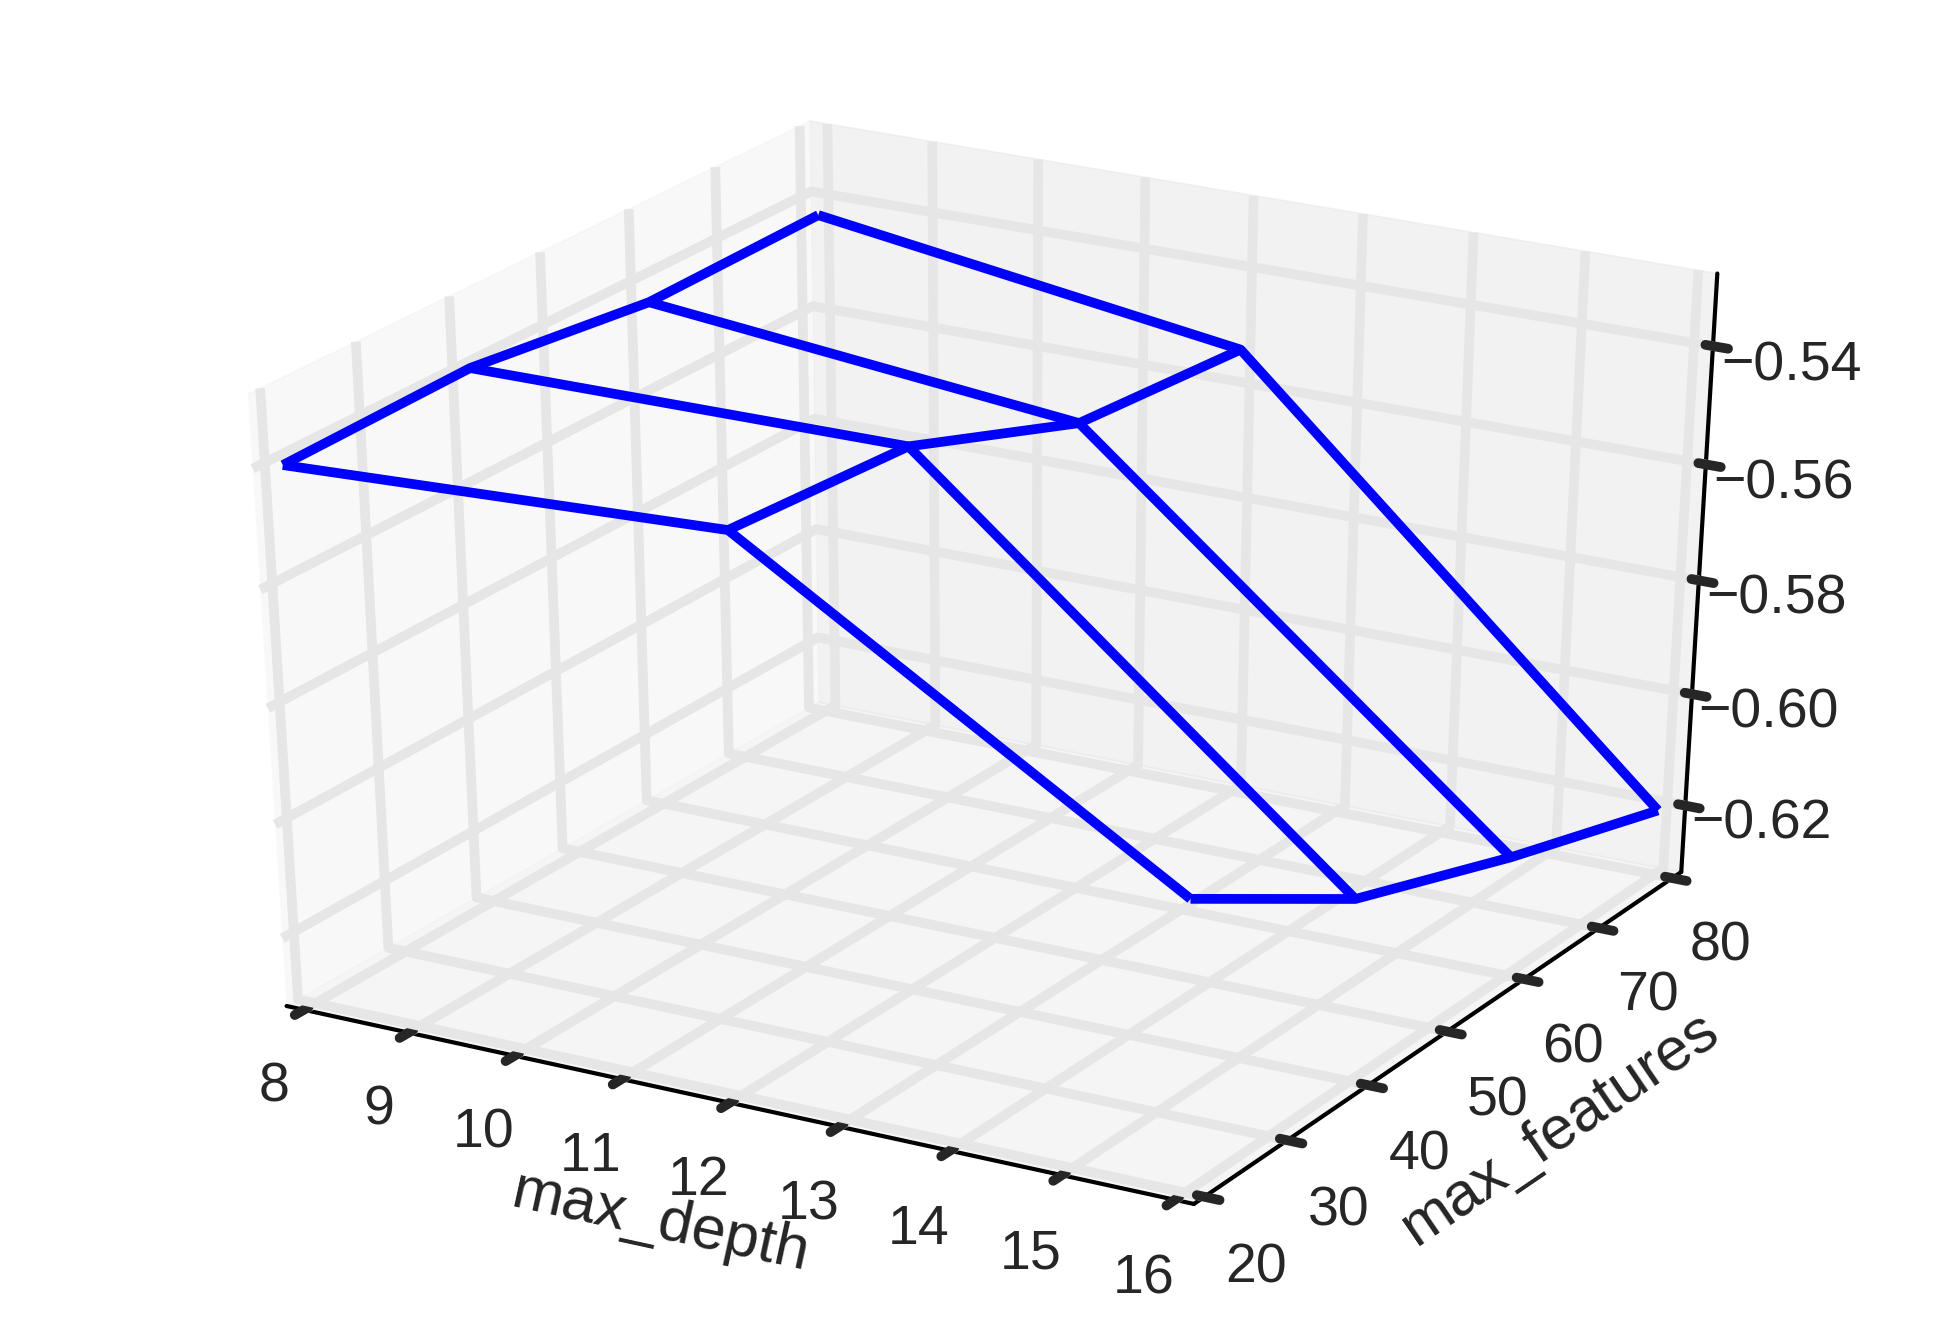

learning_rate  max_depth  max_features  n_estimators     score
0             0.1          8            20            64 -0.539835
1             0.1          8            40            64 -0.539224
2             0.1          8            60            64 -0.543092
3             0.1          8            80            64 -0.542691
4             0.1         12            20            64 -0.536656
5             0.1         12            40            64 -0.538873
6             0.1         12            60            64 -0.550495
7             0.1         12            80            64 -0.553191
8             0.1         16            20            64 -0.582043
9             0.1         16            40            64 -0.600232
10            0.1         16            60            64 -0.611005
11            0.1         16            80            64 -0.620402

In [52]:
%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 400
plot_scores_from_data_frame(scores, 'max_depth', 'max_features')
scores

In [53]:
param_grid = {
    'n_estimators':[64],
    'learning_rate':[0.075, 0.1],
    'max_depth':[8],
    'max_features':[5, 10, 15, 20]

}
clf = GradientBoostingClassifier()
scores = grid_search(clf, param_grid, X, y)

In [55]:
scores

learning_rate  max_depth  max_features  n_estimators     score
0          0.075          8             5            64 -0.598437
1          0.075          8            10            64 -0.562969
2          0.075          8            15            64 -0.553193
3          0.075          8            20            64 -0.548273
4          0.100          8             5            64 -0.566780
5          0.100          8            10            64 -0.547146
6          0.100          8            15            64 -0.539815
7          0.100          8            20            64 -0.539835

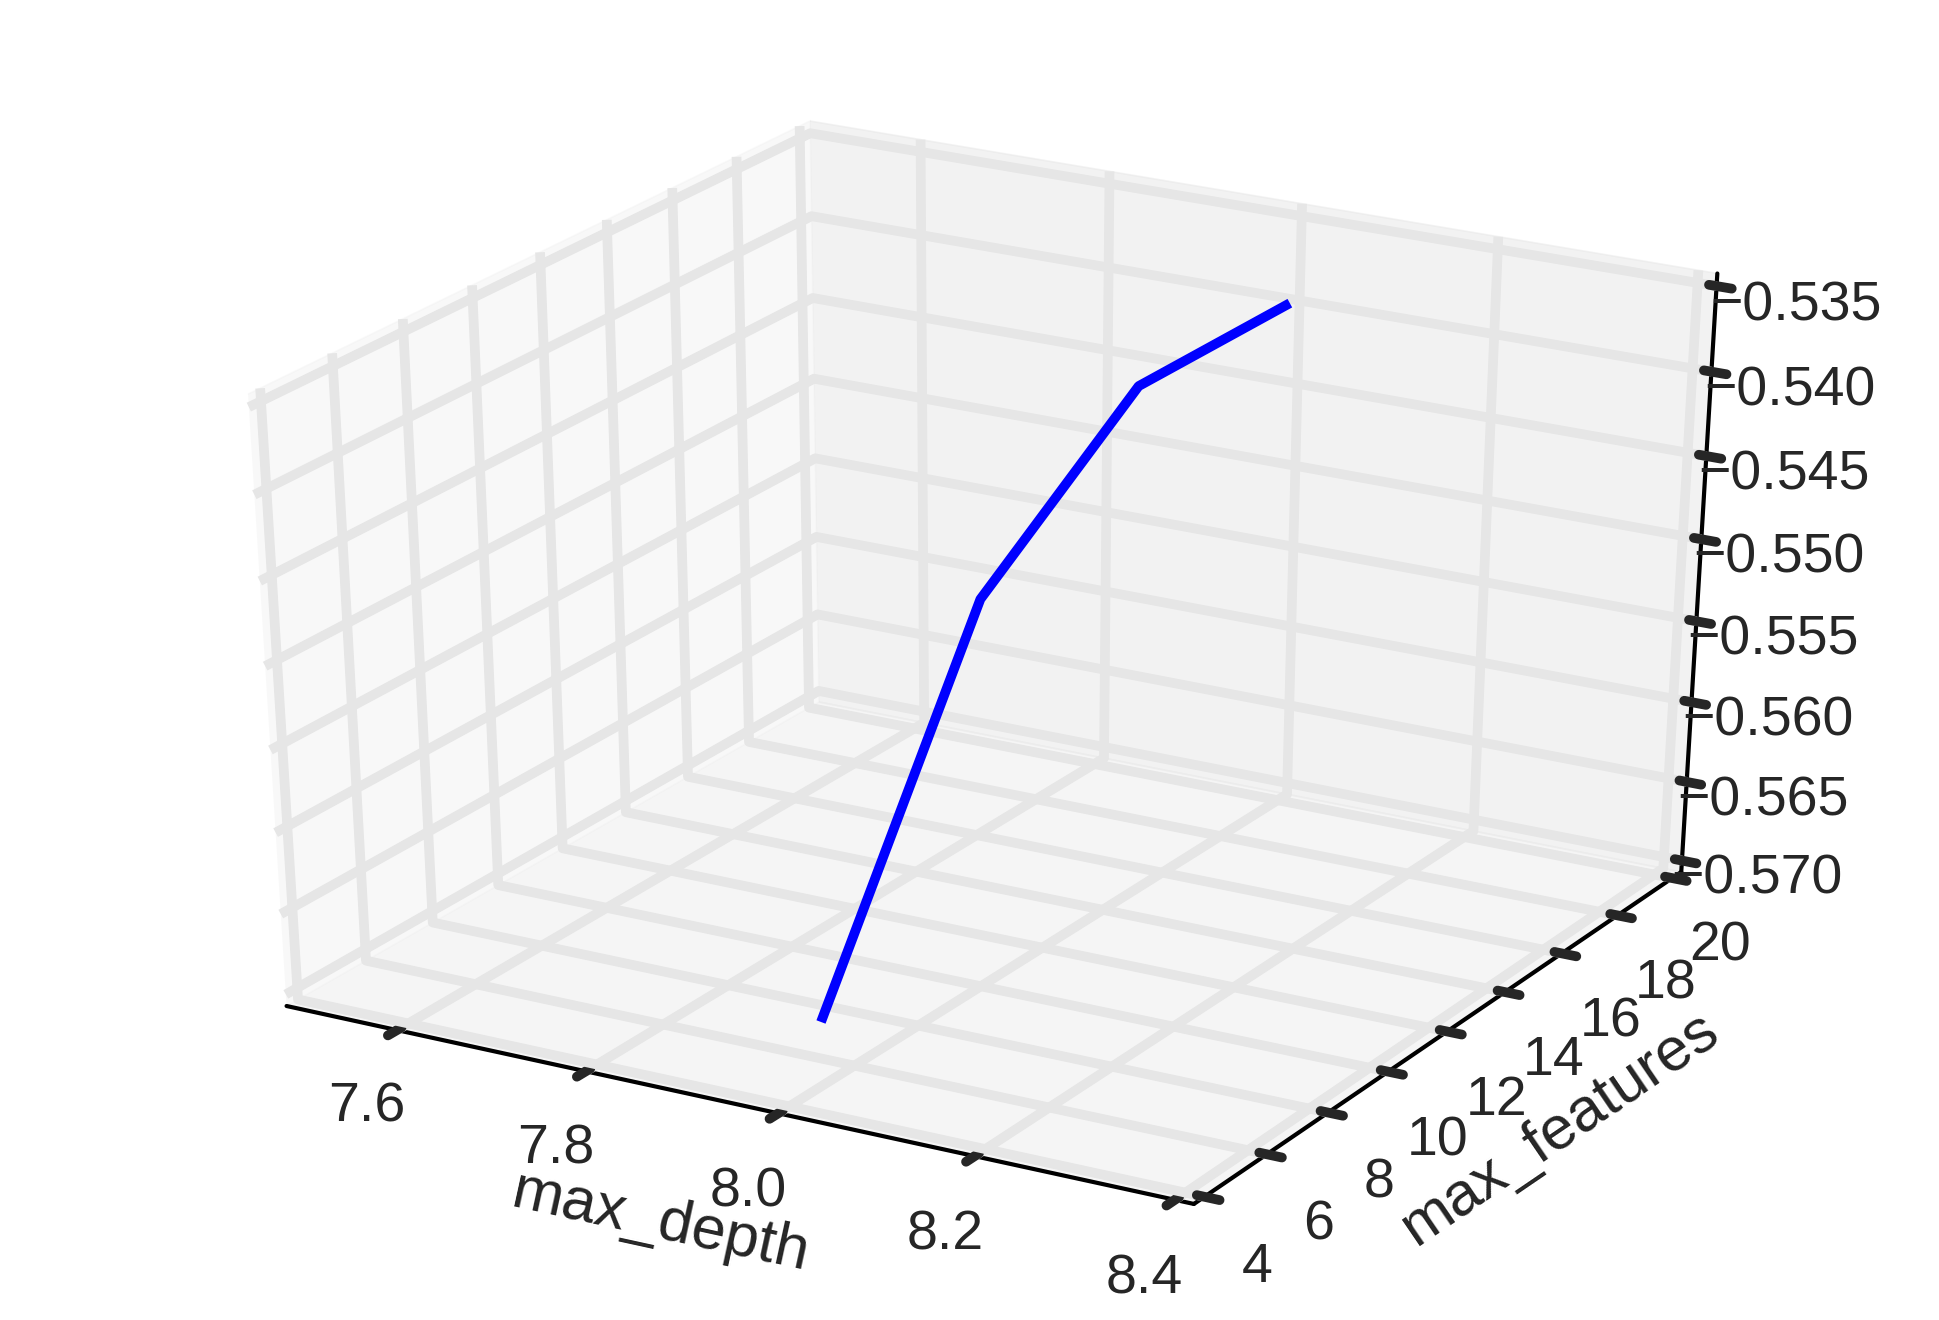

learning_rate  max_depth  max_features  n_estimators     score
0          0.075          8             5            64 -0.598437
1          0.075          8            10            64 -0.562969
2          0.075          8            15            64 -0.553193
3          0.075          8            20            64 -0.548273
4          0.100          8             5            64 -0.566780
5          0.100          8            10            64 -0.547146
6          0.100          8            15            64 -0.539815
7          0.100          8            20            64 -0.539835

In [54]:
%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 400
plot_scores_from_data_frame(scores, 'max_depth', 'max_features')
scores

Таким образом мы нашли оптимальные параметры: глубина $-$ 8, число признаков $-$ 15.

## SVC

Support vector classification или методв опорных векторов является методом регуляризации Тихонова, частным случаем Ridge regression. Алгоритм ищет оптимальные опорные вектора $\mathbf{w_i}$ и константы $b_i$ для разделения точек в пространстве гиперплоскостями
$$\mathbf{w_i}\cdot \mathbf{x}-b_i=0$$
Для построения прогноза должна использоваться одна из функций Кернела. Анализ информации на форуме соревнования привел нас к использованию стандартной для метода экспоненциальной функции:
$$e^{-\gamma\cdot|\mathbf{x}-\mathbf{x'}|^2}$$
Параметр $\gamma$ и параметр штрафа $C$ определим экспериментально.

In [20]:
from sklearn.svm import SVC

In [17]:
clf = SVC()
param_grid = {
    'C': np.logspace(-3, 1, 5),
    'gamma':np.logspace(-3, 1, 5),
    'probability':[True]
}

scores = grid_search(clf, param_grid, X, y)
scores

C   gamma probability     score
0    0.001   0.001        True -1.358256
1    0.001   0.010        True -1.217185
2    0.001   0.100        True -1.060790
3    0.001   1.000        True -0.832415
4    0.001  10.000        True -1.137317
5    0.010   0.001        True -1.172642
6    0.010   0.010        True -1.062407
7    0.010   0.100        True -0.787916
8    0.010   1.000        True -0.748930
9    0.010  10.000        True -1.072577
10   0.100   0.001        True -1.040654
11   0.100   0.010        True -0.739319
12   0.100   0.100        True -0.660657
13   0.100   1.000        True -0.621994
14   0.100  10.000        True -0.953864
15   1.000   0.001        True -0.731879
16   1.000   0.010        True -0.653123
17   1.000   0.100        True -0.597383
18   1.000   1.000        True -0.524956
19   1.000  10.000        True -0.808552
20  10.000   0.001        True -0.656680
21  10.000   0.010        True -0.609621
22  10.000   0.100        True -0.551078
23  10.000   1.000        True -0.498531
24  10.000  10.000        True -0.790201

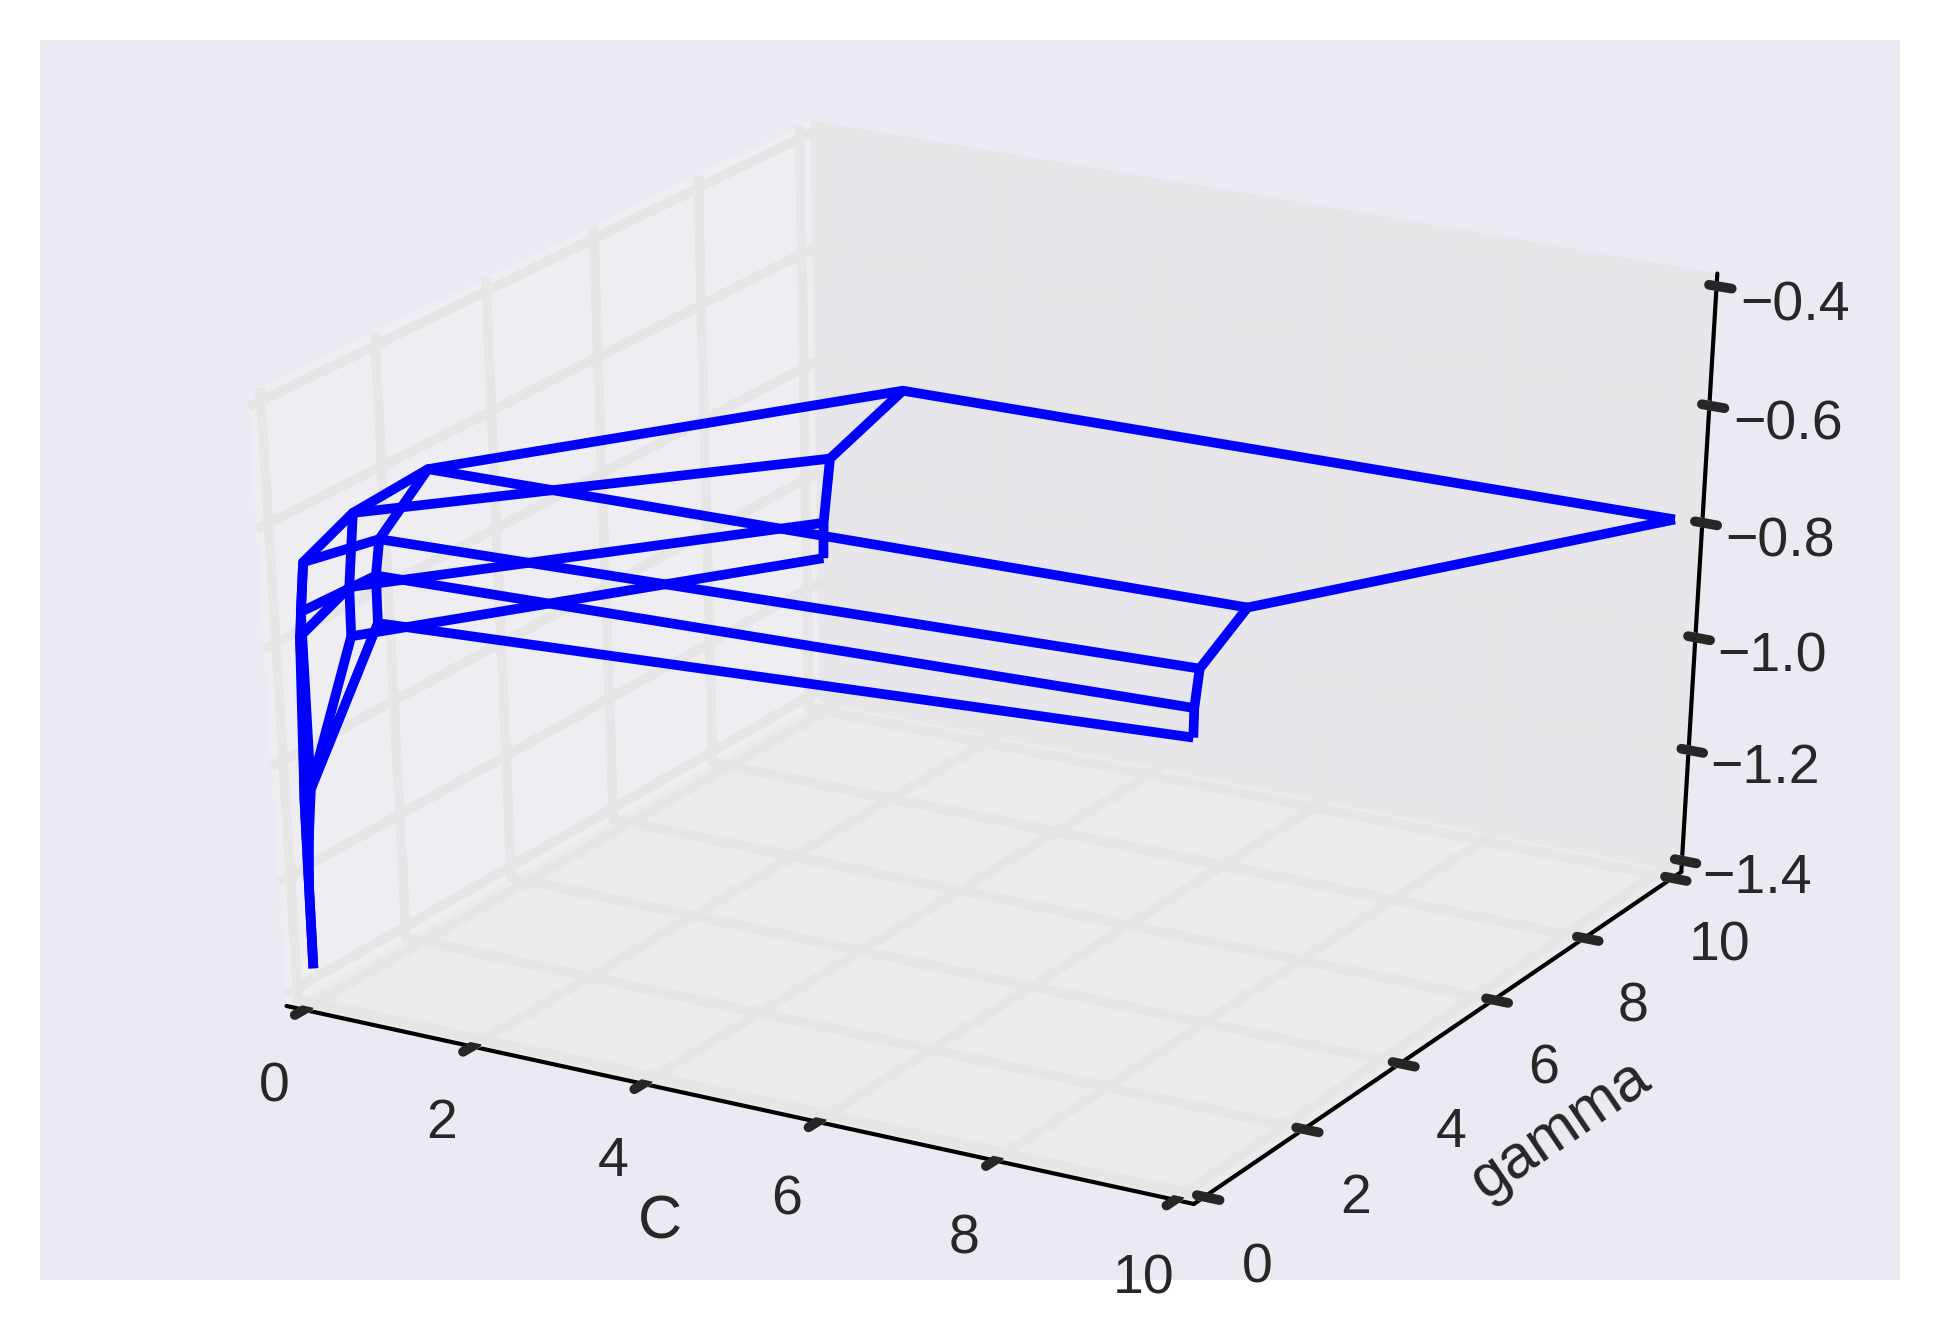

In [26]:
plot_scores_from_data_frame(scores, 'C', 'gamma')

In [27]:
clf = SVC()
param_grid = {
    'C': np.logspace(0.5, 1.5, 3),
    'gamma':np.logspace(-0.5, 0.5, 3),
    'probability':[True]
}

scores = grid_search(clf, param_grid, X, y)
scores

C     gamma probability     score
0   3.162278  0.316228        True -0.530836
1   3.162278  1.000000        True -0.500451
2   3.162278  3.162278        True -0.523718
3  10.000000  0.316228        True -0.507352
4  10.000000  1.000000        True -0.498455
5  10.000000  3.162278        True -0.526916
6  31.622777  0.316228        True -0.502547
7  31.622777  1.000000        True -0.507709
8  31.622777  3.162278        True -0.532271

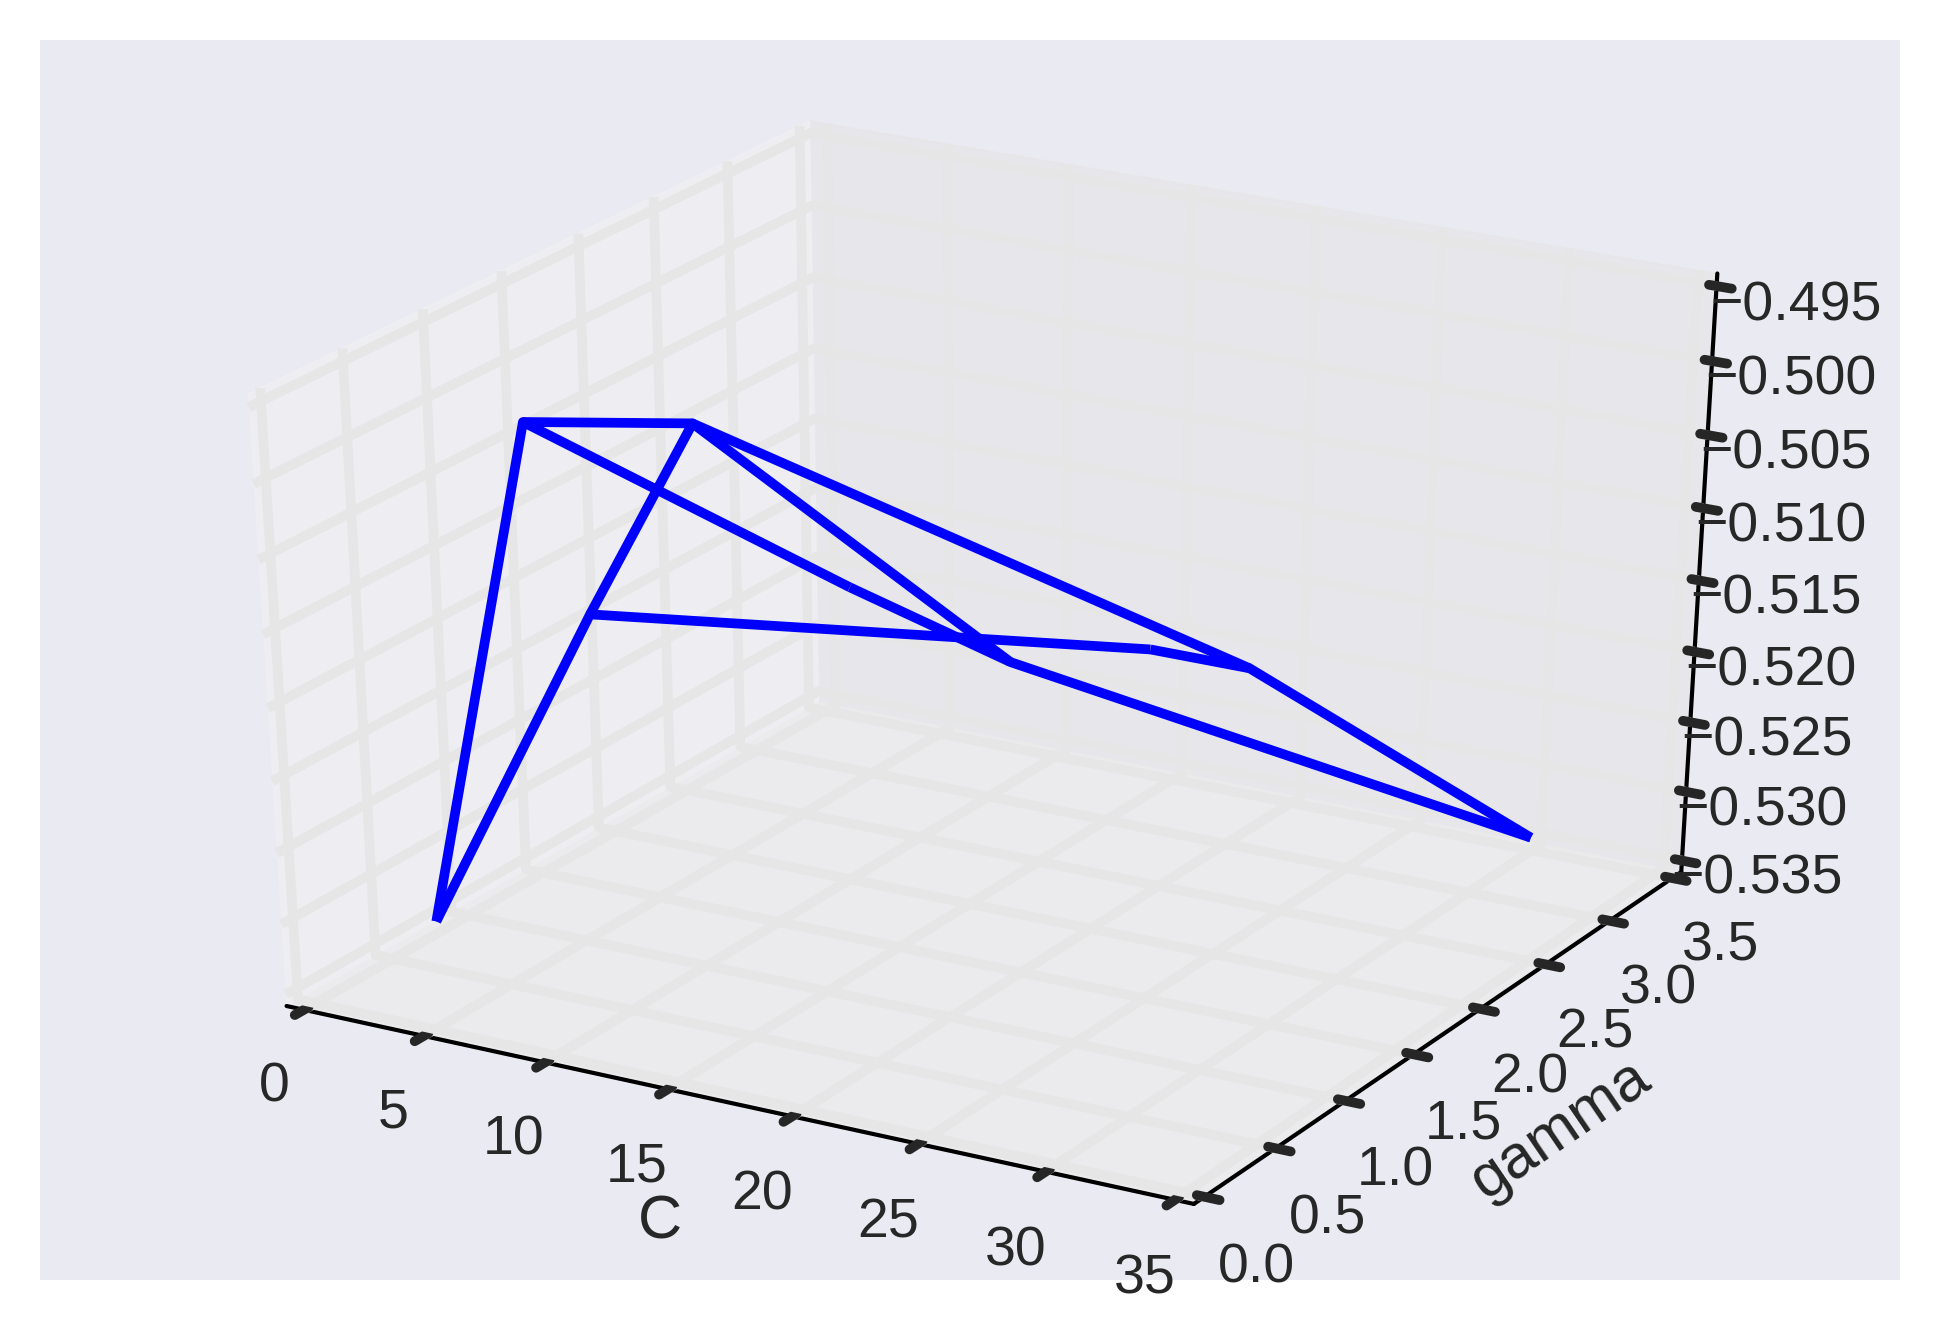

In [28]:
plot_scores_from_data_frame(scores, 'C', 'gamma')

Оптимальные параметры:

$\\C=10.0 \\\gamma=1.0$

## XGBoost

Воспользуемся градиентным бустингом из библиотеки xgboost.

Прооптимизируем его так же, как и предыдущие методы бустинга.

Параметры варьирования:

Глубина дерева

learning_rate $-$ коэффициент обучения

subsample $-$ доля объектов, используемых для построения дерева

colsample_bytree $-$ доля признаков, используемых для построения дерева

n_estimators $-$ число деревьев в ансамбле

In [30]:
from xgboost import XGBClassifier
clf = XGBClassifier(max_depth = 8, learning_rate=0.3, subsample=0.8, colsample_bytree=0.8)
param_grid = {
    'max_depth': [8],
    'learning_rate':[0.1, 0.2, 0.3],
    'subsample':[0.7, 0.8, 0.9],
    'colsample_bytree':[0.7, 0.8, 0.9],
    'n_estimators':[64]
}

clf = GridSearchCV(clf, cv=cv, param_grid=param_grid, scoring='log_loss', refit=False)
clf.fit(X, y)
scores = get_pandas_scores(clf.grid_scores_)
scores

colsample_bytree  learning_rate  max_depth  n_estimators     score silent  \
0                0.7            0.1          8            64 -0.548196  False   
1                0.7            0.1          8            64 -0.546477  False   
2                0.7            0.1          8            64 -0.547901  False   
3                0.7            0.2          8            64 -0.516502  False   
4                0.7            0.2          8            64 -0.511574  False   
5                0.7            0.2          8            64 -0.513999  False   
6                0.7            0.3          8            64 -0.511588  False   
7                0.7            0.3          8            64 -0.510989  False   
8                0.7            0.3          8            64 -0.511231  False   
9                0.8            0.1          8            64 -0.546302  False   
10               0.8            0.1          8            64 -0.544939  False   
11               0.8            0.1          8            64 -0.546111  False   
12               0.8            0.2          8            64 -0.510738  False   
13               0.8            0.2          8            64 -0.507204  False   
14               0.8            0.2          8            64 -0.511121  False   
15               0.8            0.3          8            64 -0.514986  False   
16               0.8            0.3          8            64 -0.509673  False   
17               0.8            0.3          8            64 -0.508594  False   
18               0.9            0.1          8            64 -0.543736  False   
19               0.9            0.1          8            64 -0.543070  False   
20               0.9            0.1          8            64 -0.544131  False   
21               0.9            0.2          8            64 -0.511723  False   
22               0.9            0.2          8            64 -0.508411  False   
23               0.9            0.2          8            64 -0.511968  False   
24               0.9            0.3          8            64 -0.512267  False   
25               0.9            0.3          8            64 -0.504505  False   
26               0.9            0.3          8            64 -0.513477  False   

    subsample  
0         0.7  
1         0.8  
2         0.9  
3         0.7  
4         0.8  
5         0.9  
6         0.7  
7         0.8  
8         0.9  
9         0.7  
10        0.8  
11        0.9  
12        0.7  
13        0.8  
14        0.9  
15        0.7  
16        0.8  
17        0.9  
18        0.7  
19        0.8  
20        0.9  
21        0.7  
22        0.8  
23        0.9  
24        0.7  
25        0.8  
26        0.9

In [16]:
clf = XGBClassifier(max_depth = 8, learning_rate=0.3, subsample=0.8, colsample_bytree=0.8)
param_grid = {
    'max_depth': [6, 12, 16, 20],
    'learning_rate':[0.25],
    'subsample':[0.8],
    'colsample_bytree':[0.8],
    'n_estimators':[256],
}

clf = GridSearchCV(clf, cv=cv, param_grid=param_grid, scoring='log_loss', refit=False)
clf.fit(X, y)
scores = get_pandas_scores(clf.grid_scores_)
scores

colsample_bytree  learning_rate  max_depth  n_estimators     score  \
0               0.8           0.25          6           256 -0.508096   
1               0.8           0.25         12           256 -0.575225   
2               0.8           0.25         16           256 -0.604143   
3               0.8           0.25         20           256 -0.615155   

   subsample  
0        0.8  
1        0.8  
2        0.8  
3        0.8

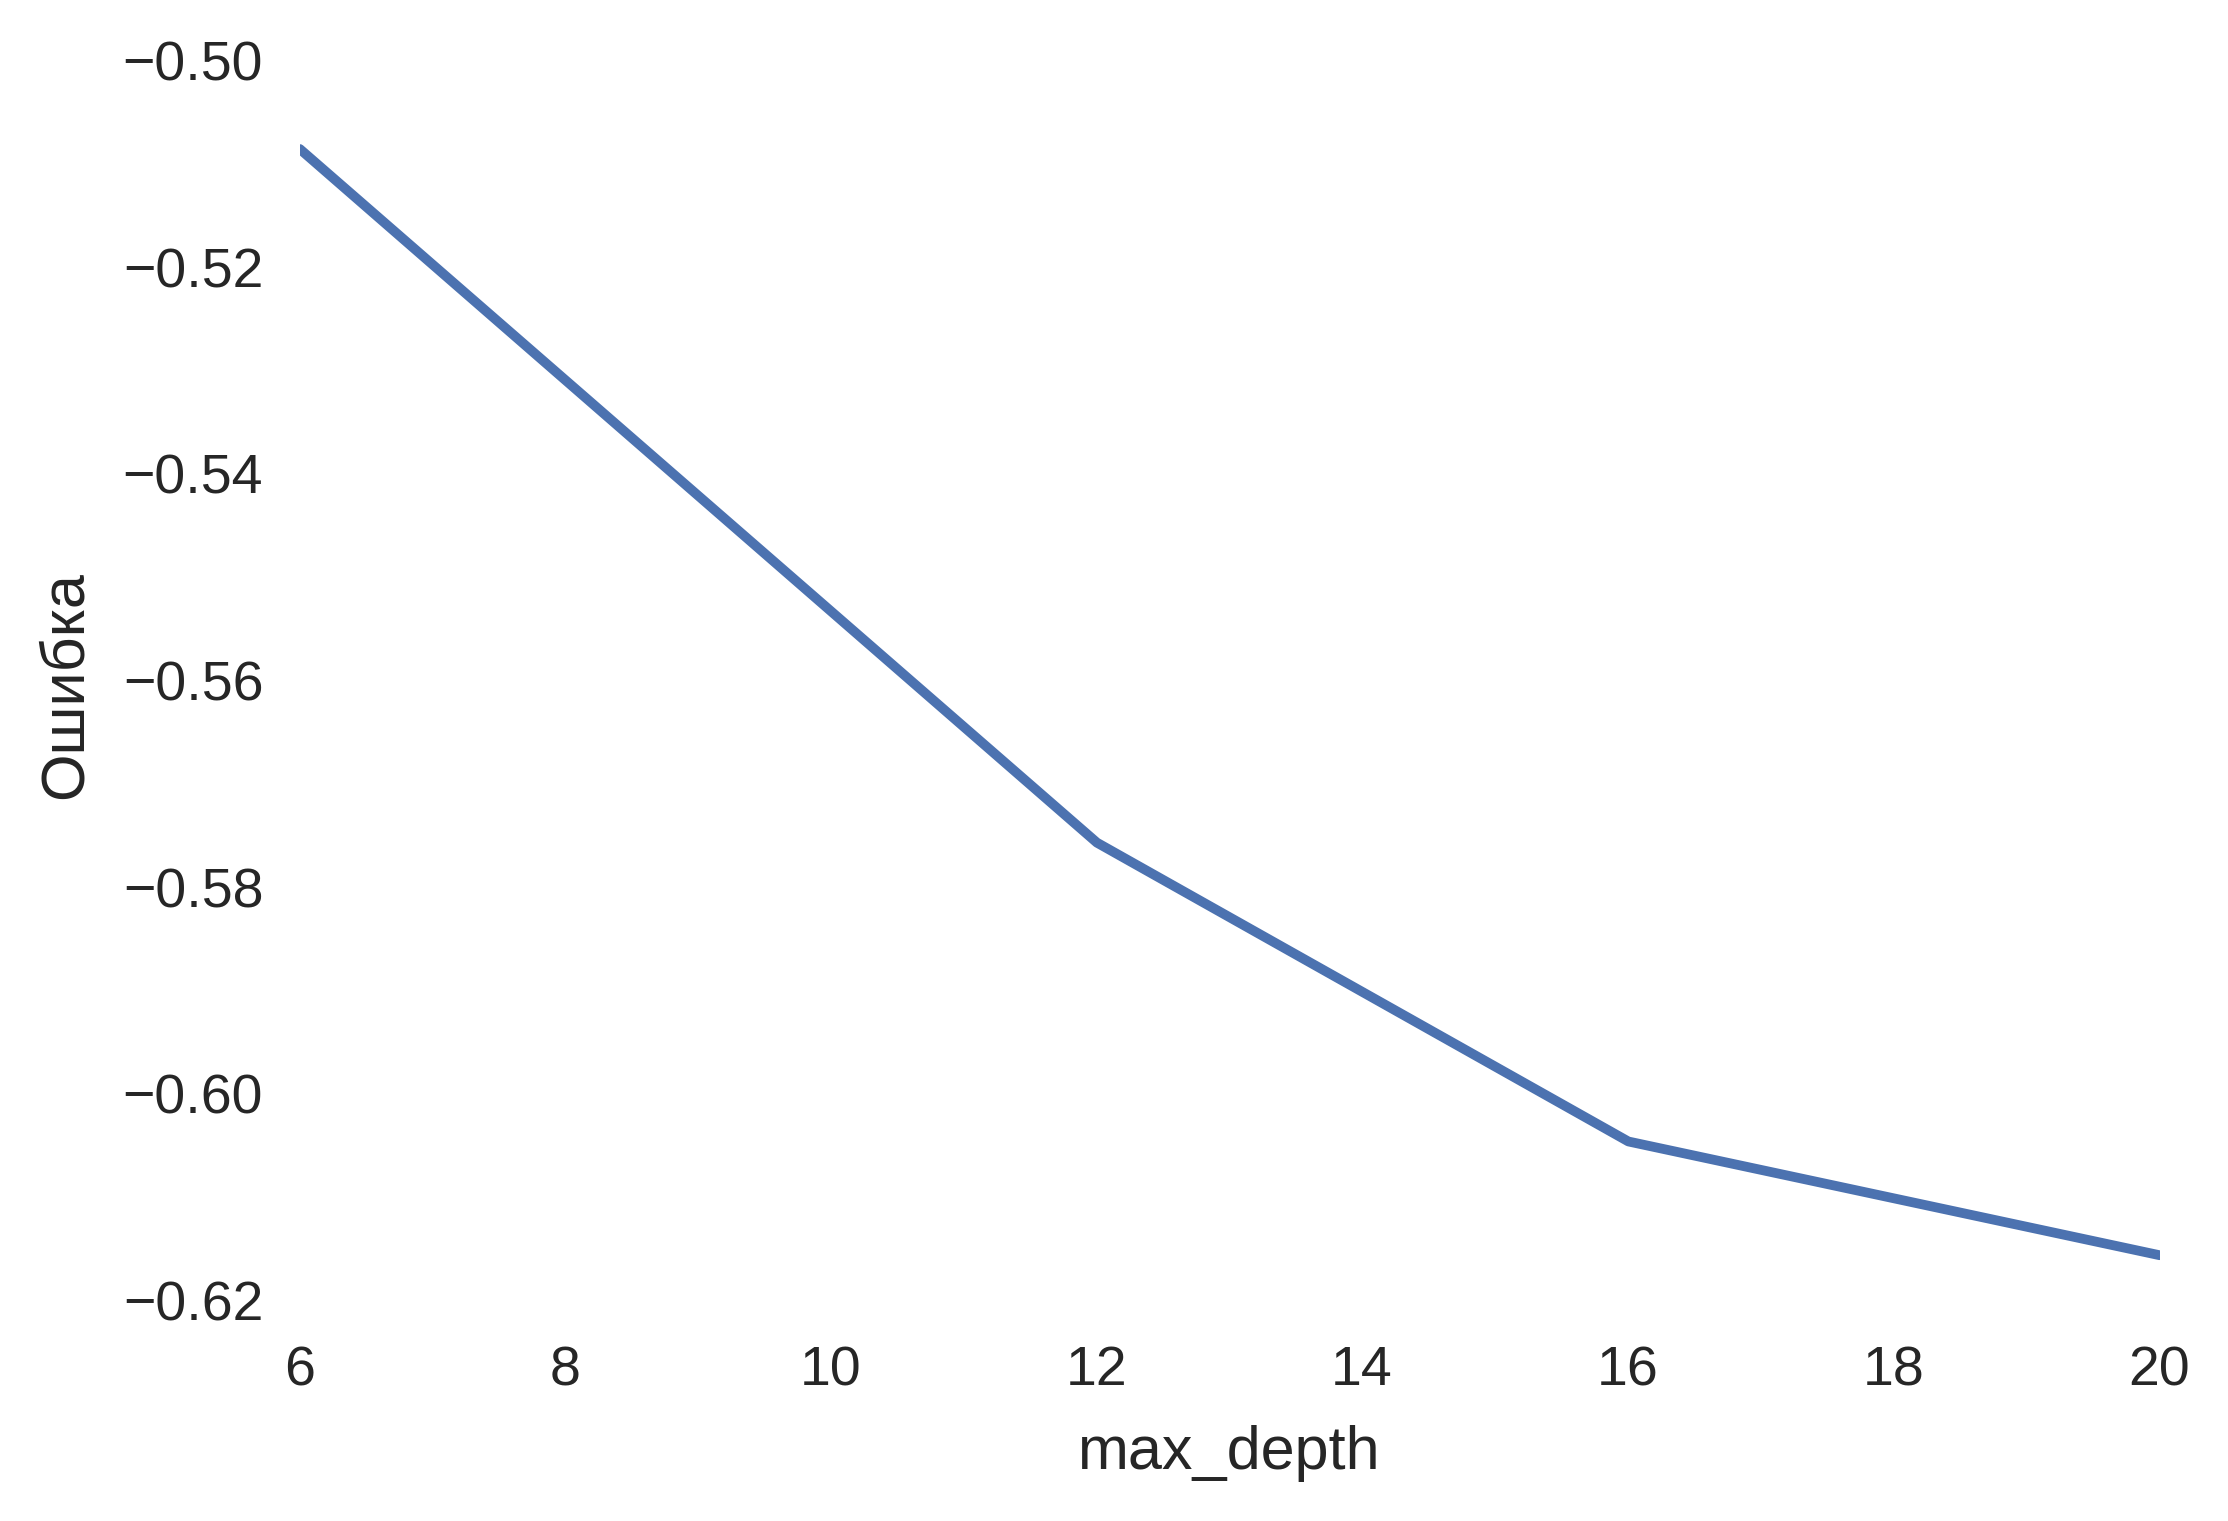

In [17]:
plt.plot(scores.max_depth, scores.score)
plt.xlabel('max_depth')
plt.ylabel('Ошибка')
plt.show()

In [95]:
clf = XGBClassifier(max_depth = 8, learning_rate=0.3, subsample=0.8, colsample_bytree=0.8)
param_grid = {
    'max_depth': [10],
    'learning_rate':[0.05, 0.1],
    'subsample':[0.8],
    'colsample_bytree':[0.8],
    'n_estimators':[128, 196, 256],
}

clf = GridSearchCV(clf, cv=cv, param_grid=param_grid, scoring='log_loss', refit=False)
clf.fit(X, y)
scores = get_pandas_scores(clf.grid_scores_)
scores

colsample_bytree  learning_rate  max_depth  n_estimators     score silent  \
0               0.8           0.05         10           128 -0.524599  False   
1               0.8           0.05         10           196 -0.498652  False   
2               0.8           0.05         10           256 -0.489585  False   
3               0.8           0.10         10           128 -0.493028  False   
4               0.8           0.10         10           196 -0.486996  False   
5               0.8           0.10         10           256 -0.489445  False   

   subsample  
0        0.8  
1        0.8  
2        0.8  
3        0.8  
4        0.8  
5        0.8

In [20]:
from xgboost import XGBClassifier
param = {
    'max_depth': 10,
    'learning_rate':0.05,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'n_estimators':348
}
xgb_clf = XGBClassifier(**param)
xgb_clf.fit(X[train], y[train])
log_loss(y[test], xgb_clf.predict_proba(X[test]))

0.48380939530680739

Найденные оптимальные параметры:

Глубина дерева $-$ 10

learning_rate $-$ 0.05 

subsample $-$ 0.8

colsample_bytree $-$ 0.8

n_estimators $-$ 348


#Объединение алгоритмов

Достигнув хороших результатов на каждом методе по отдельности, объединим все сильные классификаторы в один очень сильный.
Для этого сначала обучим все классификаторы на полученных параметрах.

In [17]:
log_clf = LogisticRegression(C=20.0)
X_fe = engineer_features(data_for_X, add_zeroes=True)
log_clf.fit(X_fe[train], y[train])

rf_clf = RandomForestClassifier(criterion='gini', max_depth=34, max_features=30, n_estimators=256, random_state=0)
rf_clf.fit(X[train], y[train])

erf_clf = ExtraTreesClassifier(criterion='gini', max_depth=40, max_features=60, n_estimators=256, random_state=0)
erf_clf.fit(X[train], y[train])

gb_clf = GradientBoostingClassifier(learning_rate=0.1, max_depth=8, max_features=15, n_estimators=64)
gb_clf.fit(X[train], y[train])

param = {
    'max_depth': 10,
    'learning_rate':0.05,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'n_estimators':348
}
xgb_clf = XGBClassifier(**param)
xgb_clf.fit(X[train], y[train])

svc_clf = SVC(C=10.0, gamma=1.0, probability=True)
svc_clf.fit(X[train], y[train])

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=1.0,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Ниже представлены данные о точности каждого из использованных нами методов, кроме AdaBoost, который мы отбросили из-за его неэффективности.

In [18]:
predictions = []
predictions.append(log_clf.predict_proba(X_fe[test]))
predictions.append(rf_clf.predict_proba(X[test]))
predictions.append(erf_clf.predict_proba(X[test]))
predictions.append(gb_clf.predict_proba(X[test]))
predictions.append(xgb_clf.predict_proba(X[test]))
predictions.append(svc_clf.predict_proba(X[test]))
[log_loss(y[test], p) for p in predictions]

[0.60665950709848626,
 0.56455012249135372,
 0.5323983278097929,
 0.54336042440932764,
 0.48380939530680739,
 0.498441456840576]

Для обучения итогового классификатора будем использовать 75% от данных для тестирования из предыдущего пункта.
Таким образом для тестирования итогового классификатора останется доля, равная $0.25\cdot 0.25= 0.0625$.

Итоговое предсказание попробуем найти в форме взвешенной комбинации степеней предсказаний алгоритмов:
$$\hat{p}=\sum\limits_{i=1}^6 \alpha_i p_i^{\gamma_i}$$
Для этого будем оптимизировать этот прогноз при помощи функции минимизации из библиотеки SciPy. Зададим изначальные веса $\alpha_i=\gamma_i=1$. Для того, чтобы полученный ответ был устойчивым, зададим ограничения $0\leq \alpha_i,\gamma_i\leq 10$.

In [58]:
from scipy.optimize import minimize

In [59]:
def normalize(X):
    for i in range(X.shape[0]):
        X[i] /= np.sum(X[i])
    return X

In [60]:
def loss(x, lim):
    group_prediction = np.zeros(predictions[0].shape)
    for i, prediction in enumerate(predictions):
        group_prediction += x[i * 2] * prediction ** x[i * 2 + 1]
    group_prediction = normalize(group_prediction)
    return log_loss(y[test][lim], group_prediction[lim])

In [61]:
from scipy.optimize import minimize

bounds = [(0.0, 10.0)] * len(predictions) * 2

group_cv = ShuffleSplit(predictions[0].shape[0], n_iter=1, test_size=0.25, random_state=0)
group_train, group_test = next(iter(group_cv))

result = minimize(lambda x: loss(x, group_train),
                  [1.0, 1.0] * 6, tol=1e-3, bounds=bounds)
result

     fun: 0.46158002871011605
 success: True
     nit: 6
 message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  status: 0
    nfev: 112
       x: array([ 0.        ,  1.67623419,  0.45065114,  1.75176148,  1.10627951,
        1.46668975,  0.45687624,  1.78420263,  1.        ,  1.        ,
        1.7821906 ,  1.14968721])
     jac: array([ 0.00021925,  0.        ,  0.00132245, -0.00021849, -0.00047124,
        0.00012578,  0.00121042, -0.00019043,  0.        ,  0.        ,
        0.00081881, -0.00281614])

Можно заметить, что в данном классификаторе, после оптимизации параметров, не используется логистическая регрессия

Посмотрим, какой точностью обладает полученная комбинация.

In [62]:
loss(result.x, group_test)

0.45814727144598694

Повторим теперь поиск оптимального прогноза при помощи других методов: Logistic regression, Random Forest, ExtraTreeClassifier и XGBoost.

In [20]:
group_prediction = np.hstack(predictions)
group_prediction.shape

(15470, 54)

In [64]:
group_clf = LogisticRegression()
param_grid = {
    'C':np.logspace(-1, 3, 50)
}

scores = grid_search(group_clf, param_grid, group_prediction, y[test], cv=group_cv)

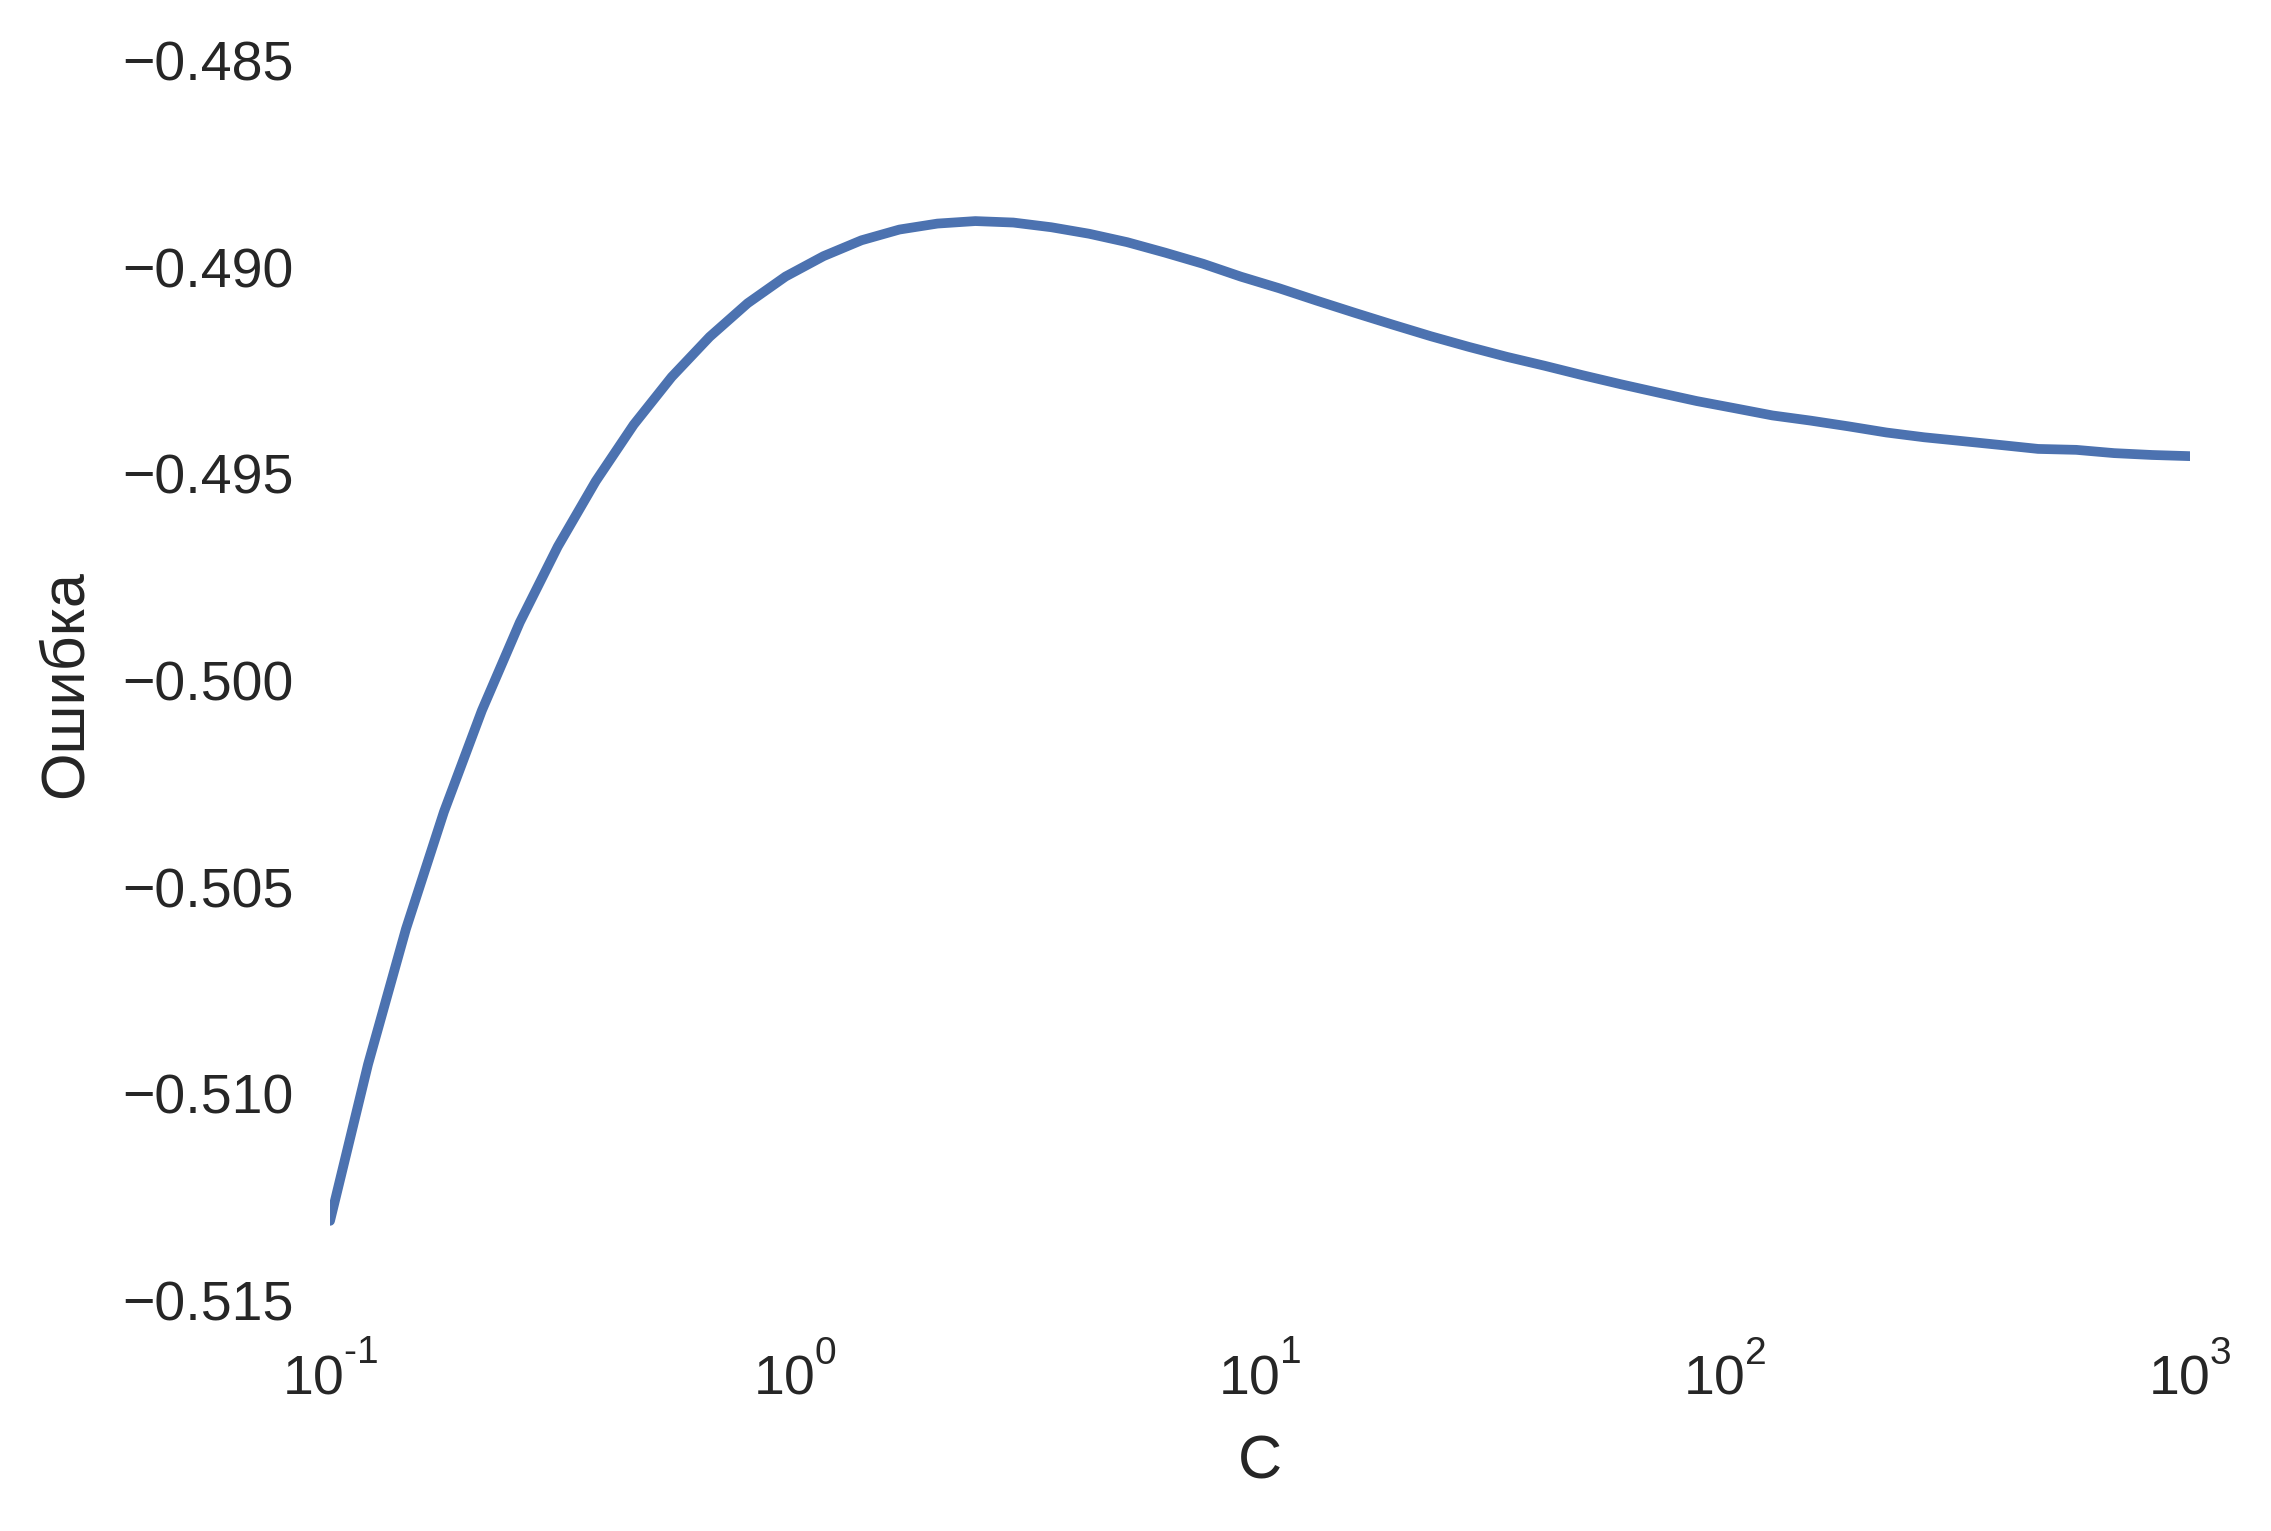

In [65]:
plt.plot(scores['C'], scores.score)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Ошибка')
plt.show()

In [66]:
group_clf = RandomForestClassifier()
param_grid = {
    'max_depth':[8, 10, 12],
    'max_features':[20, 24, 28],
    'n_estimators':[256]
}

scores = grid_search(group_clf, param_grid, group_prediction, y[test], cv=group_cv)
scores

max_depth  max_features  n_estimators     score
0          8            20           256 -0.492187
1          8            24           256 -0.491743
2          8            28           256 -0.493304
3         10            20           256 -0.479176
4         10            24           256 -0.485783
5         10            28           256 -0.485659
6         12            20           256 -0.480704
7         12            24           256 -0.480260
8         12            28           256 -0.484728

In [67]:
group_clf = ExtraTreesClassifier()
param_grid = {
    'max_depth':[12, 14, 16],
    'max_features':[22, 24, 26],
    'n_estimators':[1024]
}

scores = grid_search(group_clf, param_grid, group_prediction, y[test], cv=group_cv)
scores

max_depth  max_features  n_estimators     score
0         12            22          1024 -0.479571
1         12            24          1024 -0.478113
2         12            26          1024 -0.478249
3         14            22          1024 -0.474068
4         14            24          1024 -0.473776
5         14            26          1024 -0.473831
6         16            22          1024 -0.471140
7         16            24          1024 -0.471527
8         16            26          1024 -0.471338

In [68]:
param_grid = {
    'max_depth': [2, 3],
    'learning_rate':[0.025],
    'subsample':[0.5, 0.8, 1.0],
    'colsample_bytree':[0.5, 0.8, 1.0],
    'n_estimators':[360]
}
group_clf = XGBClassifier()
group_clf = GridSearchCV(group_clf, param_grid=param_grid, cv=group_cv, scoring='log_loss')
group_clf.fit(group_prediction, y[test])

GridSearchCV(cv=ShuffleSplit(15470, n_iter=1, test_size=0.25, random_state=0),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, n_estimators=100,
       nthread=-1, objective='binary:logistic', seed=0, silent=True,
       subsample=1),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'max_depth': [2, 3], 'n_estimators': [360], 'colsample_bytree': [0.5, 0.8, 1.0], 'subsample': [0.5, 0.8, 1.0], 'learning_rate': [0.025]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='log_loss', verbose=0)

In [69]:
get_pandas_scores(group_clf.grid_scores_)

colsample_bytree  learning_rate  max_depth  n_estimators     score  \
0                0.5          0.025          2           360 -0.453163   
1                0.5          0.025          2           360 -0.452641   
2                0.5          0.025          2           360 -0.453177   
3                0.5          0.025          3           360 -0.451004   
4                0.5          0.025          3           360 -0.450044   
5                0.5          0.025          3           360 -0.452133   
6                0.8          0.025          2           360 -0.452734   
7                0.8          0.025          2           360 -0.452459   
8                0.8          0.025          2           360 -0.452592   
9                0.8          0.025          3           360 -0.451686   
10               0.8          0.025          3           360 -0.449498   
11               0.8          0.025          3           360 -0.452392   
12               1.0          0.025          2           360 -0.452965   
13               1.0          0.025          2           360 -0.451919   
14               1.0          0.025          2           360 -0.452530   
15               1.0          0.025          3           360 -0.451982   
16               1.0          0.025          3           360 -0.449708   
17               1.0          0.025          3           360 -0.454107   

    subsample  
0         0.5  
1         0.8  
2         1.0  
3         0.5  
4         0.8  
5         1.0  
6         0.5  
7         0.8  
8         1.0  
9         0.5  
10        0.8  
11        1.0  
12        0.5  
13        0.8  
14        1.0  
15        0.5  
16        0.8  
17        1.0

In [70]:
param_grid = {
    'max_depth': [1, 2, 3],
    'learning_rate':[0.022, 0.025, 0.03],
    'subsample':[0.8],
    'colsample_bytree':[0.8],
    'n_estimators':[512]
}
group_clf = XGBClassifier()
group_clf = GridSearchCV(group_clf, param_grid=param_grid, cv=group_cv, scoring='log_loss')
group_clf.fit(group_prediction, y[test])

GridSearchCV(cv=ShuffleSplit(15470, n_iter=1, test_size=0.25, random_state=0),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, n_estimators=100,
       nthread=-1, objective='binary:logistic', seed=0, silent=True,
       subsample=1),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3], 'n_estimators': [512], 'colsample_bytree': [0.8], 'subsample': [0.8], 'learning_rate': [0.022, 0.025, 0.03]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='log_loss', verbose=0)

In [71]:
get_pandas_scores(group_clf.grid_scores_)

colsample_bytree  learning_rate  max_depth  n_estimators     score  \
0               0.8          0.022          1           512 -0.454433   
1               0.8          0.022          2           512 -0.449866   
2               0.8          0.022          3           512 -0.449567   
3               0.8          0.025          1           512 -0.453178   
4               0.8          0.025          2           512 -0.449940   
5               0.8          0.025          3           512 -0.449311   
6               0.8          0.030          1           512 -0.451912   
7               0.8          0.030          2           512 -0.449922   
8               0.8          0.030          3           512 -0.450704   

   subsample  
0        0.8  
1        0.8  
2        0.8  
3        0.8  
4        0.8  
5        0.8  
6        0.8  
7        0.8  
8        0.8

In [75]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate':[0.022],
    'subsample':[0.8],
    'colsample_bytree':[0.8],
    'n_estimators':[512]
}
group_clf = XGBClassifier()
group_clf = GridSearchCV(group_clf, param_grid=param_grid, cv=group_cv, scoring='log_loss')
group_clf.fit(group_prediction, y[test])
scores = get_pandas_scores(group_clf.grid_scores_)
scores

colsample_bytree  learning_rate  max_depth  n_estimators     score  \
0               0.8          0.022          3           512 -0.449567   
1               0.8          0.022          5           512 -0.456180   
2               0.8          0.022          7           512 -0.476742   

   subsample  
0        0.8  
1        0.8  
2        0.8

Оптимизация при помощи XGBoost дала точность большую, чем библиотека из SciPy. Таким образом, XGBoost повысил точность дважды: как один из методов классификации и как метод нахождения коэффициентов.

Обучим итоговый классификатор на основе XGBoost для отправки результатов на kaggle

In [21]:
group_clf = XGBClassifier()
param = {
    'max_depth': 3,
    'learning_rate':0.022,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'n_estimators':512
}
group_clf = XGBClassifier(**param)
group_clf.fit(group_prediction, y[test])

XGBClassifier(base_score=0.5, colsample_bytree=0.8, gamma=0,
       learning_rate=0.022, max_delta_step=0, max_depth=3,
       min_child_weight=1, n_estimators=512, nthread=-1,
       objective='multi:softprob', seed=0, silent=True, subsample=0.8)

In [22]:
def prediction_function_with_xgb(data_for_X):
    predictions = []
    X = engineer_features(data_for_X)
    X_fe = engineer_features(data_for_X, add_zeroes=True)
    predictions.append(log_clf.predict_proba(X_fe))
    predictions.append(rf_clf.predict_proba(X))
    predictions.append(erf_clf.predict_proba(X))
    predictions.append(gb_clf.predict_proba(X))
    predictions.append(xgb_clf.predict_proba(X))
    predictions.append(svc_clf.predict_proba(X))
    
    group_prediction = np.hstack(predictions)
    
    return group_clf.predict_proba(group_prediction)

In [23]:
produce_submission(prediction_function=prediction_function_with_xgb)

#Результаты и выводы

В итоге нами был проведен анализ 7 методов на конкретной задаче. Каждый из методов был прооптимизирован до определенной точности при помощи подбора подходящих параметров. Параметры выбирались исходя из экспериментальных таблиц и графиков. После определения окрестности оптимума проводилось масштабирование и повторный поиск.

После этого все методы были объединены в один классификатор, который также был оптимизирован: сначала при помощи поиска подходящих параметров линейной комбинации степеней, а потом при помощи стандартных методов анализа. Итоговый классификатор обладал точностью, которая превосходила точность любого базового классификатора в отдельности.

Опишем некоторые особенности методов, обнаруженные нами в ходе работы.

Logistic regression. Данный метод не показал хороших результатов на этих данных. Это может быть вызвано тем, что данные распределены неравномерно с большим преобладанием малых значений, а метод является линейным по входным данным. Вероятно, именно поэтому добавление бинарных признаков значительно увеличило его точность. Примечательно, что по итогам оптимизирования итогового классификатора логистическая регрессия имела коэффициент 0, то есть не использовалась.

AdaBoost. Исходя из наших экспериментов, метод не подходит для решения данной задачи.

Random Forest и Extra Trees Classifier. Эксперимент подтвердил, что увеличение числа деревьев приводит к увеличению точности. ETC показал результаты лучшие, чем RF. Возможно, имеется зашумленность данных, к которой второй метод более устойчив.

Gradient boosting. Этот бустинг потребовал большое количество времени для подбора параметров. Ожидалось, что этот классифактор не будет учитываться после оптимизации итогового классификатора из-за его схожести с более точным XGBoost. Однако практика показала обратное.

SVC. Метод опорных векторов вместе с GB был одним из самых медленных, однако показал при этом большую точность. Другим достоинством метода для этой задачи оказалось небольшое число параметров.

XGboost. Данный метод оказался наиболее точным на данной задаче. Также этот бустинг отличился более высокой скоростью обучения по сравнению с остальными методами на ансамблях. Кроме того, он смог повысить точность итогового классификатора по сравнению с оптимизацией линейной комбинации.

Возможно, для каждого из рассмотренных методов можно подобрать более подходящие параметры. Вероятно, можно добиться больших результатов, если увеличить число экспериментальных точек.

Полученная точность при тестировании на приватных данных с kaggle: 0.44449, что соответствует 611 месту из 3590 участников.